# Inerpretation-Net Training

# Experiment 1: I-Net Performance for Different Algebras and Complexities
# Experiment 2: I-Net Performance Comparison for λ-Nets with Different Training Levels
# Experiment 3: I-Net Performance Comparison Different Training Data Sizes

## Specitication of Experiment Settings

In [1]:
import time
time.sleep(int(60*60*0)) #wait 0h

In [2]:
import math
def nCr(n,r):
    f = math.factorial
    return f(n) // f(r) // f(n-r)

In [3]:
d = 3  
n = 6
sparsity = nCr(n+d, d)

x_max = 1#10 #this number excluded
x_min = -1#-10
x_step = 0.01#0.1
a_max = 10 #this number excluded
a_min = -10
a_step = 0.001

n_jobs = 11


data_size = 100000 #for loading lambda models

#specify interpretation net structure
optimizer = 'custom'#adam
dropout = 0.25
epochs = 100
batch_size = 512
interpretation_network_layers = [512, 1024]

random_evaluation_dataset_size = 500

#lambda net specifications for loading (need to be set according to lambda net training to load correct weights)
epochs_lambda = 200
batch_lambda = 64
lambda_network_layers = [5*sparsity]
optimizer_lambda = '_' + 'adam'


lambda_dataset_size = 1000

#set if multi_epoch_analysis should be performed
multi_epoch_analysis = True
each_epochs_save_lambda = 10
epoch_start = 0 #use to skip first epochs in multi_epoch_analysis

#set if samples analysis should be performed
samples_list = None#[100, 500, 750, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 28125] 

evaluate_with_real_function = True
consider_labels_training = False

same_training_all_lambda_nets = False

fixed_seed_lambda_training = True
fixed_initialization_lambda_training = False
number_different_lambda_trainings = 1

inet_holdout_seed_evaluation = False
seed_in_inet_training = False


In [4]:
##############DO NOT CHANGE###################
variables = 'abcdefghijklmnopqrstuvwxyz'[:n] 
RANDOM_SEED = 42

n_jobs = min((epochs_lambda//each_epochs_save_lambda+1, n_jobs)) if multi_epoch_analysis else min(len(samples_list), n_jobs) if samples_list!=None else 1

each_epochs_save_lambda = each_epochs_save_lambda if multi_epoch_analysis else epochs_lambda
epochs_save_range_lambda = range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda) if each_epochs_save_lambda == 1 else range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda+1) if multi_epoch_analysis else range(1,2)

advanced_metric_dataset_size = 10#200

use_gpu = False
if use_gpu:
    gpu_numbers = '0'
else:
    gpu_numbers = ''

if fixed_seed_lambda_training:
    seed_shuffle_string = '_' + str(number_different_lambda_trainings) + '-FixedSeed'
else:
    seed_shuffle_string = '_NoFixedSeed'
    
if fixed_initialization_lambda_training:
    seed_shuffle_string += '_' + str(number_different_lambda_trainings) + '-FixedEvaluation'
else:
    seed_shuffle_string += '_NoFixedEvaluation'

if same_training_all_lambda_nets:
    training_string = '_same'
else:
    training_string = '_diverse'

layers_str = ''.join([str(neurons) + '-' for neurons in lambda_network_layers])

structure = '_' + layers_str + str(epochs_lambda) + 'e' + str(batch_lambda) + 'b' + optimizer_lambda
filename = seed_shuffle_string + '_' + str(RANDOM_SEED) + structure

interpretation_network_string = 'drop' + str(dropout) + 'e' + str(epochs) + 'b' + str(batch_size) + '_' + str(interpretation_network_layers)


## Imports

In [5]:
import ttg
from itertools import product       # forms cartesian products
from tqdm import tqdm_notebook as tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer


import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers
import shutil

import logging
logging.getLogger('tensorflow').disabled = True

from prettytable import PrettyTable
import colored
import math

import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score
from similaritymeasures import frechet_dist, area_between_two_curves, dtw
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.utils import plot_model
from IPython.display import Image

import keras.backend as K
from livelossplot import PlotLossesKerasTF
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
#np.set_printoptions(suppress=True)

import tensorflow as tf
import random 
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)

try:
    # Create target Directory
    os.mkdir('./data/plotting/' + interpretation_network_string + filename + '/')
    os.mkdir('./data/results/' + interpretation_network_string + filename + '/')
except FileExistsError:
    pass

import warnings
warnings.filterwarnings('ignore')

from IPython.display import display, Math, Latex


In [6]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Utility functions

In [7]:
#General Utility Functions

ALPHABET = \
  "0123456789abcdefghijklmnopqrstuvwxyz"

def encode (n):
    try:
        return ALPHABET [n]
    except IndexError:
        raise Exception ("cannot encode: %s" % n)
        
def dec_to_base (dec = 0, base = 16):
    if dec < base:
        return encode (dec)
    else:
        return dec_to_base (dec // base, base) + encode (dec % base)

def return_float_tensor_representation(some_representation, dtype=tf.float32):
    if tf.is_tensor(some_representation):
        some_representation = tf.dtypes.cast(some_representation, dtype) 
    else:
        some_representation = tf.convert_to_tensor(some_representation)
        some_representation = tf.dtypes.cast(some_representation, dtype) 
        
    if not tf.is_tensor(some_representation):
        raise SystemExit('Given variable is no instance of ' + str(dtype) + ':' + str(some_representation))
     
    return some_representation


def return_numpy_representation(some_representation):
    if isinstance(some_representation, pd.DataFrame):
        some_representation = some_representation.values
        
    if isinstance(some_representation, list):
        some_representation = np.array(some_representation)
    
    if not isinstance(some_representation, np.ndarray):
        raise SystemExit('Given variable is no instance of ' + str(np.ndarray) + ':' + str(some_representation))
    
    return some_representation

def mergeDict(dict1, dict2):
    #Merge dictionaries and keep values of common keys in list
    newDict = {**dict1, **dict2}
    for key, value in newDict.items():
        if key in dict1 and key in dict2:
            if isinstance(dict1[key], list) and isinstance(value, list):
                newDict[key] = dict1[key]
                newDict[key].extend(value)
            elif isinstance(dict1[key], list) and not isinstance(value, list):
                newDict[key] = dict1[key]
                newDict[key].extend([value])
            elif not isinstance(dict1[key], list) and isinstance(value, list):
                newDict[key] = [dict1[key]]
                newDict[key].extend(value)
            else:
                newDict[key] = [dict1[key], value]
    return newDict

def return_callbacks_from_string(callback_string_list):
    callbacks = [] if len(callback_string_list) > 0 else None
    #if 'plot_losses_callback' in callback_string_list:
        #callbacks.append(PlotLossesCallback())
    if 'reduce_lr_loss' in callback_string_list:
        reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=epochs/10, verbose=0, min_delta=0, mode='min') #epsilon
        callbacks.append(reduce_lr_loss)
    if 'early_stopping' in callback_string_list:
        earlyStopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=0, verbose=0, mode='min')
        callbacks.append(earlyStopping)
        
    #if not multi_epoch_analysis and samples_list == None: 
        #callbacks.append(TQDMNotebookCallback())
        
    return callbacks

def arreq_in_list(myarr, list_arrays):
    return next((True for elem in list_arrays if np.array_equal(elem, myarr)), False)

def generate_random_x_values(size, x_max, x_min, x_step, numnber_of_variables, seed=42):
    
    if random.seed != None:
        random.seed(seed)
    
    x_values_list = []
    
    for j in range(size):
        values = np.round(np.array(random_product(np.arange(x_min, x_max, x_step), repeat=numnber_of_variables)), int(-np.log10(x_step)))
        while arreq_in_list(values, x_values_list):
                values = np.round(np.array(random_product(np.arange(x_min, x_max, x_step), repeat=numnber_of_variables)), int(-np.log10(x_step)))         
        x_values_list.append(values)
    
    return np.array(x_values_list)

def flatten(l):
    for el in l:
        if isinstance(el, Iterable) and not isinstance(el, (str, bytes)):
            yield from flatten(el)
        else:
            yield el
            
def print_polynomial_from_coefficients(coefficients):

    global list_of_monomial_identifiers
    
    string = ''
    for identifier, coefficient in zip(list_of_monomial_identifiers, coefficients):
        string += str(np.round(coefficient, 2))
        for index, variable_identifier in enumerate(identifier):  
            if int(variable_identifier) == 1:
                #string += '*'
                string += 'abcdefghijklmnopqrstuvwxyz'[index]
            elif int(variable_identifier) > 1:
                #string += '*'
                string += 'abcdefghijklmnopqrstuvwxyz'[index] + '^' + str(variable_identifier)
    
        string += ' + '
        
    latex_string = "$" + string[:-3] + "$"
    
    return display(Math(latex_string))


In [8]:
class LambdaNetDataset():
    lambda_net_list = None
    
    weight_list = None
    
    train_settings_list = None
    index_list = None
    
    target_polynomial_list = None
    lstsq_lambda_pred_polynomial_list = None
    lstsq_target_polynomial_list = None    
        
    test_data_list = None
    
    def __init__(self, lambda_net_list):
        self.lambda_net_list = lambda_net_list
        
        self.weight_list = [lambda_net.weights for lambda_net in lambda_net_list]
        
        self.train_settings_list = {}
        for key in lambda_net_list[0].train_settings.keys():
            self.train_settings_list[key] = []   
        for lambda_net in lambda_net_list:
            for key in lambda_net.train_settings.keys():
                self.train_settings_list[key].append(lambda_net.train_settings[key])
        
        self.index_list = [lambda_net.index for lambda_net in lambda_net_list]
        
        self.target_polynomial_list = [lambda_net.target_polynomial for lambda_net in lambda_net_list]
        self.lstsq_lambda_pred_polynomial_list = [lambda_net.lstsq_lambda_pred_polynomial for lambda_net in lambda_net_list]
        self.lstsq_target_polynomial_list = [lambda_net.lstsq_target_polynomial for lambda_net in lambda_net_list]
      
        self.test_data_list = [lambda_net.test_data for lambda_net in lambda_net_list]
    
    def __repr__(self):
        return str(self.as_pandas().head())
    def __str__(self):
        return str(self.as_pandas().head())
    
    def __len__(self):
        return len(self.lambda_net_list)
    
    
    def make_prediction_on_dataset(self, evaluation_dataset):  
        assert(evaluation_dataset.shape[1] == n)
        lambda_network_preds_list = []
        
        for weights in self.weight_list:
            lambda_network_preds = weights_to_pred(weights, evaluation_dataset)
            lambda_network_preds_list.append(lambda_network_preds)
        
        return np.array(lambda_network_preds_list)
    
    def make_prediction_on_test_data(self):
        lambda_network_preds_list = []
        for lambda_net in self.lambda_net_list:
            lambda_network_preds = lambda_net.make_prediction_on_test_data()
            lambda_network_preds_list.append(lambda_network_preds)
            
        return np.array(lambda_network_preds_list)
                
        
    def return_target_poly_fvs_on_dataset(self, evaluation_dataset):
        assert(evaluation_dataset.shape[1] == n, 'evaluation dataset has wrong shape ' + str(evaluation_dataset.shape + ' but required (x, ' + str(n) + ')'))     
        target_poly_fvs_list = parallel_fv_calculation_from_polynomial(self.target_polynomial_list, [evaluation_dataset for _ in range(len(self.target_polynomial_list))])
            
        return np.array(target_poly_fvs_list)
    
    def return_target_poly_fvs_on_test_data(self):        
        target_poly_fvs_list = parallel_fv_calculation_from_polynomial(self.target_polynomial_list, self.test_data_list)
        
        return np.array(target_poly_fvs_list)
    
    def return_lstsq_lambda_pred_polynomial_fvs_on_dataset(self, evaluation_dataset):
        assert(evaluation_dataset.shape[1] == n, 'evaluation dataset has wrong shape ' + str(evaluation_dataset.shape + ' but required (x, ' + str(n) + ')'))    
        lstsq_lambda_pred_polynomial_fvs_list = parallel_fv_calculation_from_polynomial(self.lstsq_lambda_pred_polynomial_list, [evaluation_dataset for _ in range(len(self.target_polynomial_list))])
            
        return np.array(lstsq_lambda_pred_polynomial_fvs_list)
    
    def return_lstsq_lambda_pred_polynomial_fvs_on_test_data(self):
        lstsq_lambda_pred_polynomial_fvs_list = parallel_fv_calculation_from_polynomial(self.lstsq_lambda_pred_polynomial_list, self.test_data_list)
            
        return np.array(lstsq_lambda_pred_polynomial_fvs_list)
    
    def return_lstsq_target_polynomial_fvs_on_dataset(self, evaluation_dataset):
        assert(evaluation_dataset.shape[1] == n, 'evaluation dataset has wrong shape ' + str(evaluation_dataset.shape + ' but required (x, ' + str(n) + ')'))
        lstsq_target_polynomial_fvs_list = parallel_fv_calculation_from_polynomial(self.lstsq_target_polynomial_list, [evaluation_dataset for _ in range(len(self.target_polynomial_list))])
            
        return np.array(lstsq_target_polynomial_fvs_list)
    
    def return_lstsq_target_polynomial_fvs_on_test_data(self):
        lstsq_target_polynomial_fvs_list = parallel_fv_calculation_from_polynomial(self.lstsq_target_polynomial_list, self.test_data_list)
            
        return np.array(lstsq_target_polynomial_fvs_list)
    
    def as_pandas(self):  
        lambda_dataframe = pd.DataFrame(data=[lambda_net.as_array() for lambda_net in self.lambda_net_list], 
                                columns=self.lambda_net_list[0].return_column_names(), 
                                index=[lambda_net.index for lambda_net in self.lambda_net_list])
        lambda_dataframe['seed'] = lambda_dataframe['seed'].astype(int)
        
        return lambda_dataframe

    
    def get_lambda_nets_by_seed(self, seed_list):
        lambda_nets_by_seed = []
        for lambda_net in self.lambda_net_list:
            if lambda_net.train_settings['seed'] in seed_list:
                lambda_nets_by_seed.append(lambda_net)
    
        return LambdaNetDataset(lambda_nets_by_seed)
    
    def get_lambda_nets_by_lambda_index(self, lambda_index_list):
        lambda_nets_by_lambda_index = []
        for lambda_net in self.lambda_net_list:
            if lambda_net.index in lambda_index_list:
                lambda_nets_by_lambda_index.append(lambda_net)
    
        return LambdaNetDataset(lambda_nets_by_lambda_index) 
    
    def get_lambda_net_by_lambda_index(self, lambda_index):
        for lambda_net in self.lambda_net_list:
            if lambda_net.index in lambda_index:
                return lambda_net
    
        return None
    
    def sample(self, size, seed=42):
        
        assert(isinstance(size, int) or isinstance(size, float), 'Wrong sample size specified')
        
        random.seed(seed)
        
        sample_lambda_net_list = None
        if isinstance(size, int):
            sample_lambda_net_list = random.sample(self.lambda_net_list, size)
        elif isinstance(size, float):
            size = int(np.round(len(self.lambda_net_list)*size))
            sample_lambda_net_list = random.sample(self.lambda_net_list, size)
            
        return LambdaNetDataset(sample_lambda_net_list)
    

class LambdaNet():
    weights = None
    model = None
    
    train_settings = None
    index = None
    
    target_polynomial = None
    lstsq_lambda_pred_polynomial = None
    lstsq_target_polynomial = None
    
    test_data = None
    
    def __init__(self, line):
        assert(isinstance(line, np.ndarray), 'line is no array: ' + str(line))
        
        self.index = int(line[0])
        try:
            self.train_settings = {'seed': int(line[1])}
        except ValueError:
            self.train_settings = {'seed': -1}
            
        self.target_polynomial = line[range(2, nCr(n+d, d)+2)].astype(float)
        self.lstsq_lambda_pred_polynomial = line[range(nCr(n+d, d)+2, nCr(n+d, d)*2+2)].astype(float)
        self.lstsq_target_polynomial = line[range(nCr(n+d, d)*2+2, nCr(n+d, d)*3+2)].astype(float)
        assert(self.target_polynomial.shape[0] == sparsity, 'target polynomial has incorrect shape ' + str(self.target_polynomial.shape[0]) + ' but should be ' + str(sparsity))
        assert(self.lstsq_lambda_pred_polynomial.shape[0] == sparsity, 'lstsq lambda pred polynomial has incorrect shape ' + str(self.lstsq_lambda_pred_polynomial.shape[0]) + ' but should be ' + str(sparsity))
        assert(self.lstsq_target_polynomial.shape[0] == sparsity, 'lstsq target polynomial has incorrect shape ' + str(self.lstsq_target_polynomial.shape[0]) + ' but should be ' + str(sparsity))    
        
        self.weights = line[nCr(n+d, d)*3+2:].astype(float)
        assert(self.weights.shape[0] == number_of_lambda_weights, 'weights have incorrect shape ' + str(self.weights.shape[0]) + ' but should be ' + str(number_of_lambda_weights))
        
        directory = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/'
        path = directory + 'lambda_' + str(self.index) + '_test_data.npy'
        
        self.test_data = np.load(path)
        assert(self.test_data.shape[1] == n, 'test data has wrong shape ' + str(self.test_data.shape) + ' but required (x, ' + str(n) + ')')
        
    def __repr__(self):
        return str(self.weights)
    def __str__(self):
        return str(self.weights)
        
    def make_prediction_on_dataset(self, evaluation_dataset):  
        assert(evaluation_dataset.shape[1] == n) 
        lambda_network_preds = weights_to_pred(self.weights, evaluation_dataset)
        
        return lambda_network_preds
    
    def make_prediction_on_test_data(self):        
        lambda_network_preds = weights_to_pred(self.weights, self.test_data)
        
        return lambda_network_preds               
        
    def return_target_poly_fvs_on_dataset(self, evaluation_dataset):
        assert(evaluation_dataset.shape[1] == n, 'evaluation dataset has wrong shape ' + str(evaluation_dataset.shape) + ' but required (x, ' + str(n) + ')')
        target_poly_fvs = parallel_fv_calculation_from_polynomial([self.target_polynomial], [evaluation_dataset])
    
        return target_poly_fvs
    
    def return_target_poly_fvs_on_test_data(self):
        target_poly_fvs = parallel_fv_calculation_from_polynomial([self.target_polynomial], [self.test_data])
    
        return target_poly_fvs    
    
    
    
    def return_lstsq_lambda_pred_polynomial_fvs_on_dataset(self, evaluation_dataset):
        assert(evaluation_dataset.shape[1] == n, 'evaluation dataset has wrong shape ' + str(evaluation_dataset.shape) + ' but required (x, ' + str(n) + ')')
        lstsq_lambda_pred_polynomial_fvs = parallel_fv_calculation_from_polynomial([self.lstsq_lambda_pred_polynomial], [evaluation_dataset])
    
        return lstsq_lambda_pred_polynomial_fvs
    
    def return_lstsq_lambda_pred_polynomial_fvs_on_test_data(self):
        lstsq_lambda_pred_polynomial_fvs = parallel_fv_calculation_from_polynomial([self.lstsq_lambda_pred_polynomial], [self.test_data])
    
        return lstsq_lambda_pred_polynomial_fvs     
    
    def return_lstsq_target_polynomial_fvs_on_dataset(self, evaluation_dataset):
        assert(evaluation_dataset.shape[1] == n, 'evaluation dataset has wrong shape ' + str(evaluation_dataset.shape) + ' but required (x, ' + str(n) + ')')
        lstsq_target_polynomial_fvs = parallel_fv_calculation_from_polynomial([self.lstsq_target_polynomial], [evaluation_dataset])
    
        return lstsq_target_polynomial_fvs
    
    def return_lstsq_target_polynomial_fvs_on_test_data(self):
        lstsq_target_polynomial_fvs = parallel_fv_calculation_from_polynomial([self.lstsq_target_polynomial], [self.test_data])
    
        return lstsq_target_polynomial_fvs  
    
    def as_pandas(self): 
        columns = return_column_names(self)
        data = as_array(self)
        
        df = pd.DataFrame(data=data, columns=columns, index=[self.index])
        df['seed'] = df['seed'].astype(int)
        
        return df
    
    def as_array(self):
        data = np.hstack([self.train_settings['seed'], self.target_polynomial, self.lstsq_lambda_pred_polynomial, self.lstsq_target_polynomial, self.weights])
        return data
    
    def return_column_names(self):
        target_polynomial_identifiers = [monomial_identifiers + str('-target') for monomial_identifiers in list_of_monomial_identifiers]
        lstsq_lambda_pred_polynomial_identifiers = [monomial_identifiers + str('-lstsq_lambda') for monomial_identifiers in list_of_monomial_identifiers]
        lstsq_target_polynomial_identifiers = [monomial_identifiers + str('-lstsq_target') for monomial_identifiers in list_of_monomial_identifiers]

        weight_identifiers = ['wb_' + str(i) for i in range(self.weights.shape[0])]
        
        columns = list(flatten(['seed', target_polynomial_identifiers, lstsq_lambda_pred_polynomial_identifiers, lstsq_target_polynomial_identifiers, weight_identifiers]))
                
        return columns 

    
    
    
def split_LambdaNetDataset(dataset, test_split, random_seed=RANDOM_SEED):
    assert(isinstance(dataset, LambdaNetDataset))
    
    lambda_nets_list = dataset.lambda_net_list
    
    if isinstance(test_split, int) or isinstance(test_split, float):
        lambda_nets_train_list, lambda_nets_test_list = train_test_split(lambda_nets_list, test_size=test_split, random_state=random_seed)     
    elif isinstance(test_split, list):
        lambda_nets_test_list = [lambda_nets_list[i] for i in test_split]
        lambda_nets_train_list = list(set(lambda_nets_list) - set(lambda_nets_test_list))
        #lambda_nets_train_list = lambda_nets_list.copy()
        #for i in sorted(test_split, reverse=True):
        #    del lambda_nets_train_list[i]           
    assert(len(lambda_nets_list) == len(lambda_nets_train_list) + len(lambda_nets_test_list))
    
    return LambdaNetDataset(lambda_nets_train_list), LambdaNetDataset(lambda_nets_test_list)
                                                                                                 
def generate_base_model(): #without dropout
    base_model = Sequential()

    base_model.add(Dense(lambda_network_layers[0], activation='relu', input_dim=n))

    for neurons in lambda_network_layers[1:]:
        base_model.add(Dense(neurons, activation='relu'))

    base_model.add(Dense(1))
    
    return base_model

def shape_flat_weights(flat_weights, target_weights):
    
    shaped_weights =[]
    start = 0
    for el in target_weights:
        target_shape = el.shape
        size = len(list(flatten(el)))
        shaped_el = np.reshape(flat_weights[start:start+size], target_shape)
        shaped_weights.append(shaped_el)
        start += size

    return shaped_weights

def weights_to_pred(weights, x, base_model=None):

    if base_model is None:
        base_model = generate_base_model()
    else:
        base_model = keras.models.clone_model(base_model)
    
    # Shape weights (flat) into correct model structure
    shaped_weights = shape_flat_weights(weights, base_model.get_weights())
    
    # Make prediction
    base_model.set_weights(shaped_weights)
    y = base_model.predict(x).ravel()
    return y        

### Generate List of Monomial Identifiers

In [9]:
list_of_monomial_identifiers_extended = []
for i in tqdm(range((d+1)**n)):    
    monomial_identifier = dec_to_base(i, base = (d+1)).zfill(n) 
    list_of_monomial_identifiers_extended.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(nCr(n+d, d)))
print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers_extended)

list_of_monomial_identifiers = []
for monomial_identifier in tqdm(list_of_monomial_identifiers_extended):
    monomial_identifier_values = list(map(int, list(monomial_identifier)))
    if sum(monomial_identifier_values) <= d:
        list_of_monomial_identifiers.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers)))
print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(nCr(n+d, d)))
print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers)


layers_with_input_output = list(flatten([[n], lambda_network_layers, [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]

  0%|          | 0/4096 [00:00<?, ?it/s]

List length: 4096
Number of monomials in a polynomial with 6 variables and degree 3: 84
Sparsity: 84
['000000', '000001', '000002', '000003', '000010', '000011', '000012', '000013', '000020', '000021', '000022', '000023', '000030', '000031', '000032', '000033', '000100', '000101', '000102', '000103', '000110', '000111', '000112', '000113', '000120', '000121', '000122', '000123', '000130', '000131', '000132', '000133', '000200', '000201', '000202', '000203', '000210', '000211', '000212', '000213', '000220', '000221', '000222', '000223', '000230', '000231', '000232', '000233', '000300', '000301', '000302', '000303', '000310', '000311', '000312', '000313', '000320', '000321', '000322', '000323', '000330', '000331', '000332', '000333', '001000', '001001', '001002', '001003', '001010', '001011', '001012', '001013', '001020', '001021', '001022', '001023', '001030', '001031', '001032', '001033', '001100', '001101', '001102', '001103', '001110', '001111', '001112', '001113', '001120', '001121'

  0%|          | 0/4096 [00:00<?, ?it/s]

List length: 84
Number of monomials in a polynomial with 6 variables and degree 3: 84
Sparsity: 84
['000000', '000001', '000002', '000003', '000010', '000011', '000012', '000020', '000021', '000030', '000100', '000101', '000102', '000110', '000111', '000120', '000200', '000201', '000210', '000300', '001000', '001001', '001002', '001010', '001011', '001020', '001100', '001101', '001110', '001200', '002000', '002001', '002010', '002100', '003000', '010000', '010001', '010002', '010010', '010011', '010020', '010100', '010101', '010110', '010200', '011000', '011001', '011010', '011100', '012000', '020000', '020001', '020010', '020100', '021000', '030000', '100000', '100001', '100002', '100010', '100011', '100020', '100100', '100101', '100110', '100200', '101000', '101001', '101010', '101100', '102000', '110000', '110001', '110010', '110100', '111000', '120000', '200000', '200001', '200010', '200100', '201000', '210000', '300000']


## Loss/Error functions

In [10]:
#Manual TF Loss function for comparison with lambda-net prediction based (predictions made in loss function)


def mean_absolute_error_tf_fv_lambda_extended_wrapper(evaluation_dataset, list_of_monomial_identifiers, base_model):
    
    evaluation_dataset = return_float_tensor_representation(evaluation_dataset)
    list_of_monomial_identifiers = return_float_tensor_representation(list_of_monomial_identifiers)    
    
    model_lambda_placeholder = keras.models.clone_model(base_model)  
    
    weights_structure = base_model.get_weights()
    dims = [np_arrays.shape for np_arrays in weights_structure]
    
    def mean_absolute_error_tf_fv_lambda_extended(polynomial_true_with_lambda_fv, polynomial_pred):

        if seed_in_inet_training:
            network_parameters = polynomial_true_with_lambda_fv[:,sparsity+1:]
            polynomial_true = polynomial_true_with_lambda_fv[:,:sparsity]
        else:
            network_parameters = polynomial_true_with_lambda_fv[:,sparsity:]
            polynomial_true = polynomial_true_with_lambda_fv[:,:sparsity]
            
        network_parameters = return_float_tensor_representation(network_parameters)
        polynomial_true = return_float_tensor_representation(polynomial_true)
        polynomial_pred = return_float_tensor_representation(polynomial_pred)
        
        assert(polynomial_true.shape[1] == sparsity)
        assert(polynomial_pred.shape[1] == sparsity)   
        assert(network_parameters.shape[1] == number_of_lambda_weights)   
        
        return tf.math.reduce_mean(tf.map_fn(calculate_mae_fv_lambda_wrapper(evaluation_dataset, list_of_monomial_identifiers, dims, model_lambda_placeholder), (polynomial_pred, network_parameters), fn_output_signature=tf.float32))
    return mean_absolute_error_tf_fv_lambda_extended

def calculate_mae_fv_lambda_wrapper(evaluation_dataset, list_of_monomial_identifiers, dims, model_lambda_placeholder):

    def calculate_mae_fv_lambda(input_list):

        #single polynomials
        #polynomial_true = input_list[0]
        polynomial_pred = input_list[0]
        network_parameters = input_list[1]
        
        polynomial_pred_fv_list = tf.vectorized_map(calculate_fv_from_data_wrapper(list_of_monomial_identifiers, polynomial_pred), (evaluation_dataset))

        #CALCULATE LAMBDA FV HERE FOR EVALUATION DATASET
        # build models
        start = 0
        layers = []
        for i in range(len(dims)//2):
            
            # set weights of layer
            index = i*2
            size = np.product(dims[index])
            weights_tf_true = tf.reshape(network_parameters[start:start+size], dims[index])
            model_lambda_placeholder.layers[i].weights[0].assign(weights_tf_true)
            start += size
            
            # set biases of layer
            index += 1
            size = np.product(dims[index])
            biases_tf_true = tf.reshape(network_parameters[start:start+size], dims[index])
            model_lambda_placeholder.layers[i].weights[1].assign(biases_tf_true)
            start += size

        
        lambda_fv = tf.keras.backend.flatten(model_lambda_placeholder(evaluation_dataset))
        
        return tf.math.reduce_mean(tf.vectorized_map(calculate_mae_single_input, (lambda_fv, polynomial_pred_fv_list)))
    
    return calculate_mae_fv_lambda



#Manual TF Loss function for fv comparison of real and predicted polynomial

def mean_absolute_error_tf_fv_poly_extended_wrapper(evaluation_dataset, list_of_monomial_identifiers):
    
    evaluation_dataset = return_float_tensor_representation(evaluation_dataset)
    list_of_monomial_identifiers = return_float_tensor_representation(list_of_monomial_identifiers)        
    
    def mean_absolute_error_tf_fv_poly_extended(polynomial_true, polynomial_pred):

        polynomial_true = return_float_tensor_representation(polynomial_true)
        polynomial_pred = return_float_tensor_representation(polynomial_pred)
        
        assert(polynomial_true.shape[1] == sparsity, 'Shape of True Polynomial: ' + str(polynomial_true.shape))
        assert(polynomial_pred.shape[1] == sparsity, 'Shape of True Polynomial: ' + str(polynomial_pred.shape))       
        
        return tf.math.reduce_mean(tf.map_fn(calculate_mae_fv_poly_wrapper(evaluation_dataset, list_of_monomial_identifiers), (polynomial_true, polynomial_pred), fn_output_signature=tf.float32))
    return mean_absolute_error_tf_fv_poly_extended

def calculate_mae_fv_poly_wrapper(evaluation_dataset, list_of_monomial_identifiers):

    def calculate_mae_fv_poly(input_list):

        #single polynomials
        polynomial_true = input_list[0]
        polynomial_pred = input_list[1]
        
        polynomial_true_fv_list = tf.vectorized_map(calculate_fv_from_data_wrapper(list_of_monomial_identifiers, polynomial_true), (evaluation_dataset))
        polynomial_pred_fv_list = tf.vectorized_map(calculate_fv_from_data_wrapper(list_of_monomial_identifiers, polynomial_pred), (evaluation_dataset))
        
        return tf.math.reduce_mean(tf.vectorized_map(calculate_mae_single_input, (polynomial_true_fv_list, polynomial_pred_fv_list)))
    
    return calculate_mae_fv_poly





#GENERAL LOSS UTILITY FUNCTIONS
def calculate_fv_from_data_wrapper(list_of_monomial_identifiers, polynomial_pred):


    def calculate_fv_from_data(evaluation_entry):


        value_without_coefficient = tf.vectorized_map(calculate_value_without_coefficient_wrapper(evaluation_entry), (list_of_monomial_identifiers))
        polynomial_pred_value_per_term = tf.vectorized_map(lambda x: x[0]*x[1], (value_without_coefficient, polynomial_pred))
        
        polynomial_pred_fv = tf.reduce_sum(polynomial_pred_value_per_term)     
        
        return polynomial_pred_fv
    return calculate_fv_from_data


#calculate intermediate term (without coefficient multiplication)
def calculate_value_without_coefficient_wrapper(evaluation_entry):
    def calculate_value_without_coefficient(coefficient_multiplier_term):      
   
        return tf.math.reduce_prod(tf.vectorized_map(lambda x: x[0]**x[1], (evaluation_entry, coefficient_multiplier_term)))
    return calculate_value_without_coefficient

#calculate MAE at the end ---> general:REPLACE FUNCTION WITH LOSS CALL OR LAMBDA
def calculate_mae_single_input(input_list):
    true_fv = input_list[0]
    pred_fv = input_list[1]

    return tf.math.abs(tf.math.subtract(true_fv, pred_fv))




#BASIC COEFFICIENT-BASED LOSS IF X_DATA IS APPENDED
def mean_absolute_error_extended(polynomial_true_with_lambda_fv, polynomial_pred): 
    
    if seed_in_inet_training:
        assert(polynomial_true_with_lambda_fv.shape[1] == sparsity+number_of_lambda_weights+1)
    else:
        assert(polynomial_true_with_lambda_fv.shape[1] == sparsity+number_of_lambda_weights)
    
    polynomial_true = polynomial_true_with_lambda_fv[:,:sparsity]    
    
    assert(polynomial_true.shape[1] == sparsity)
    assert(polynomial_pred.shape[1] == sparsity)
    
    return tf.keras.losses.MAE(polynomial_true, polynomial_pred)


In [11]:
def r2_tf_fv_lambda_extended_wrapper(evaluation_dataset, list_of_monomial_identifiers, base_model):
    
    evaluation_dataset = return_float_tensor_representation(evaluation_dataset)
    list_of_monomial_identifiers = return_float_tensor_representation(list_of_monomial_identifiers)    
    
    model_lambda_placeholder = keras.models.clone_model(base_model)  
    
    weights_structure = base_model.get_weights()
    dims = [np_arrays.shape for np_arrays in weights_structure]
    
    def r2_tf_fv_lambda_extended(polynomial_true_with_lambda_fv, polynomial_pred):

        if seed_in_inet_training:
            network_parameters = polynomial_true_with_lambda_fv[:,sparsity+1:]
            polynomial_true = polynomial_true_with_lambda_fv[:,:sparsity]
        else:
            network_parameters = polynomial_true_with_lambda_fv[:,sparsity:]
            polynomial_true = polynomial_true_with_lambda_fv[:,:sparsity]
            
        network_parameters = return_float_tensor_representation(network_parameters)
        polynomial_true = return_float_tensor_representation(polynomial_true)
        polynomial_pred = return_float_tensor_representation(polynomial_pred)
        
        assert(polynomial_true.shape[1] == sparsity)
        assert(polynomial_pred.shape[1] == sparsity)   
        assert(network_parameters.shape[1] == number_of_lambda_weights)   
        
        return tf.math.reduce_mean(tf.map_fn(calculate_r2_fv_lambda_wrapper(evaluation_dataset, list_of_monomial_identifiers, dims, model_lambda_placeholder), (polynomial_pred, network_parameters), fn_output_signature=tf.float32))
    return r2_tf_fv_lambda_extended

def calculate_r2_fv_lambda_wrapper(evaluation_dataset, list_of_monomial_identifiers, dims, model_lambda_placeholder):

    def calculate_r2_fv_lambda(input_list):

        #single polynomials
        #polynomial_true = input_list[0]
        polynomial_pred = input_list[0]
        network_parameters = input_list[1]
        
        polynomial_pred_fv_list = tf.vectorized_map(calculate_fv_from_data_wrapper(list_of_monomial_identifiers, polynomial_pred), (evaluation_dataset))

        #CALCULATE LAMBDA FV HERE FOR EVALUATION DATASET
        # build models
        start = 0
        layers = []
        for i in range(len(dims)//2):
            
            # set weights of layer
            index = i*2
            size = np.product(dims[index])
            weights_tf_true = tf.reshape(network_parameters[start:start+size], dims[index])
            model_lambda_placeholder.layers[i].weights[0].assign(weights_tf_true)
            start += size
            
            # set biases of layer
            index += 1
            size = np.product(dims[index])
            biases_tf_true = tf.reshape(network_parameters[start:start+size], dims[index])
            model_lambda_placeholder.layers[i].weights[1].assign(biases_tf_true)
            start += size

        
        lambda_fv = tf.keras.backend.flatten(model_lambda_placeholder(evaluation_dataset))
        
        return r2_keras_loss(lambda_fv, polynomial_pred_fv_list)
    
    return calculate_r2_fv_lambda



#Manual TF Loss function for fv comparison of real and predicted polynomial

def r2_tf_fv_poly_extended_wrapper(evaluation_dataset, list_of_monomial_identifiers):
    
    evaluation_dataset = return_float_tensor_representation(evaluation_dataset)
    list_of_monomial_identifiers = return_float_tensor_representation(list_of_monomial_identifiers)        
    
    @tf.function()
    def r2_tf_fv_poly_extended(polynomial_true, polynomial_pred):

        polynomial_true = return_float_tensor_representation(polynomial_true)
        polynomial_pred = return_float_tensor_representation(polynomial_pred)
        
        assert(polynomial_true.shape[1] == sparsity, 'Shape of True Polynomial: ' + str(polynomial_true.shape))
        assert(polynomial_pred.shape[1] == sparsity, 'Shape of True Polynomial: ' + str(polynomial_pred.shape))       
        
        return tf.math.reduce_mean(tf.map_fn(calculate_r2_fv_poly_wrapper(evaluation_dataset, list_of_monomial_identifiers), (polynomial_true, polynomial_pred), fn_output_signature=tf.float32))
    return r2_tf_fv_poly_extended

def calculate_r2_fv_poly_wrapper(evaluation_dataset, list_of_monomial_identifiers):

    def calculate_r2_fv_poly(input_list):

        #single polynomials
        polynomial_true = input_list[0]
        polynomial_pred = input_list[1]
        
        polynomial_true_fv_list = tf.vectorized_map(calculate_fv_from_data_wrapper(list_of_monomial_identifiers, polynomial_true), (evaluation_dataset))
        polynomial_pred_fv_list = tf.vectorized_map(calculate_fv_from_data_wrapper(list_of_monomial_identifiers, polynomial_pred), (evaluation_dataset))
        
        return r2_keras_loss(polynomial_true_fv_list, polynomial_pred_fv_list)
    
    return calculate_r2_fv_poly



#calculate MAE at the end ---> general:REPLACE FUNCTION WITH LOSS CALL OR LAMBDA
def calculate_r2_single_input(input_list):
    true_fv = input_list[0]
    pred_fv = input_list[1]

    return r2_keras(true_fv, pred_fv)




#BASIC COEFFICIENT-BASED LOSS IF X_DATA IS APPENDED
def r2_extended(polynomial_true_with_lambda_fv, polynomial_pred): 
    
    if seed_in_inet_training:
        assert(polynomial_true_with_lambda_fv.shape[1] == sparsity+number_of_lambda_weights+1)
    else:
        assert(polynomial_true_with_lambda_fv.shape[1] == sparsity+number_of_lambda_weights)
    
    polynomial_true = polynomial_true_with_lambda_fv[:,:sparsity]    
    
    assert(polynomial_true.shape[1] == sparsity)
    assert(polynomial_pred.shape[1] == sparsity)
    
    return r2_keras(polynomial_true, polynomial_pred)

def r2_keras(y_true, y_pred, epsilon=K.epsilon()):
    
    y_true_cleared = tf.boolean_mask(y_true, tf.not_equal(return_float_tensor_representation(0), y_true))
    y_pred_cleared = tf.boolean_mask(y_pred, tf.not_equal(return_float_tensor_representation(0), y_true))

    epsilon = 1e-5
    SS_res =  K.sum(K.square(y_true_cleared - y_pred_cleared)) 
    SS_tot = K.sum(K.square(y_true_cleared - K.mean(y_true_cleared))) 
    return ( 1 - SS_res/(SS_tot + epsilon) )

def r2_keras_loss(y_true, y_pred, epsilon=K.epsilon()):
    
    #y_true = tf.boolean_mask(y_true, tf.not_equal(return_float_tensor_representation(0), y_true))
    #y_pred = tf.boolean_mask(y_pred, tf.not_equal(return_float_tensor_representation(0), y_true))

    #epsilon = 1e-5
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return  - ( 1 - SS_res/(SS_tot + epsilon) )

In [12]:
#Basic Keras/TF Loss functions
def root_mean_squared_error(y_true, y_pred):   
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)
        
    y_true =  return_float_tensor_representation(y_true)
    y_pred =  return_float_tensor_representation(y_pred)           
            
    return tf.math.sqrt(K.mean(K.square(y_pred - y_true))) 

def accuracy_multilabel(y_true, y_pred):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)
    
    y_true =  return_float_tensor_representation(y_true)
    y_pred =  return_float_tensor_representation(y_pred) 
            
    n_digits = int(-np.log10(a_step))      
    y_true = tf.math.round(y_true * 10**n_digits) / (10**n_digits) 
    y_pred = tf.math.round(y_pred * 10**n_digits) / (10**n_digits) 
        
    return K.mean(tf.dtypes.cast(tf.dtypes.cast(tf.reduce_all(K.equal(y_true, y_pred), axis=1), tf.int32), tf.float32))#tf.reduce_all(K.equal(K.equal(y_true, y_pred), True), axis=1)#K.all(K.equal(y_true, y_pred)) #K.equal(y_true, y_pred)                        

def accuracy_single(y_true, y_pred):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)
    
    y_true =  return_float_tensor_representation(y_true)
    y_pred =  return_float_tensor_representation(y_pred) 
            
    n_digits = int(-np.log10(a_step))
        
    y_true = tf.math.round(y_true * 10**n_digits) / (10**n_digits) 
    y_pred = tf.math.round(y_pred * 10**n_digits) / (10**n_digits) 
        
    return K.mean(tf.dtypes.cast(tf.dtypes.cast(K.equal(y_true, y_pred), tf.int32), tf.float32))#tf.reduce_all(K.equal(K.equal(y_true, y_pred), True), axis=1)#K.all(K.equal(y_true, y_pred)) #K.equal(y_true, y_pred)                        

def mean_absolute_percentage_error_keras(y_true, y_pred, epsilon=10e-3): 
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)
    
    y_true =  return_float_tensor_representation(y_true)
    y_pred =  return_float_tensor_representation(y_pred)        
    epsilon = return_float_tensor_representation(epsilon)
        
    return tf.reduce_mean(tf.abs(tf.divide(tf.subtract(y_pred, y_true),(y_true + epsilon))))

def huber_loss_delta_set(y_true, y_pred):
    return keras.losses.huber_loss(y_true, y_pred, delta=0.3)

In [13]:
#Manual calculations for comparison of polynomials based on function values (no TF!)

def calcualate_function_value(coefficient_list, lambda_input_entry):
    
    global list_of_monomial_identifiers
    
    result = 0   
        
    for coefficient_value, coefficient_multipliers in zip(coefficient_list, list_of_monomial_identifiers):
        value_without_coefficient = [lambda_input_value**int(coefficient_multiplier) for coefficient_multiplier, lambda_input_value in zip(coefficient_multipliers, lambda_input_entry)]

        result += coefficient_value * reduce(lambda x, y: x*y, value_without_coefficient)

    return result

def calculate_function_values_from_polynomial(polynomial, lambda_input_data):        
    function_value_list = []
        
    for lambda_input_entry in lambda_input_data:
        function_value = calcualate_function_value(polynomial, lambda_input_entry)
        function_value_list.append(function_value)

    return np.array(function_value_list)


def parallel_fv_calculation_from_polynomial(polynomial_list, lambda_input_list):
    
    polynomial_list = return_numpy_representation(polynomial_list)
    lambda_input_list = return_numpy_representation(lambda_input_list)
    
    assert(polynomial_list.shape[0] == lambda_input_list.shape[0])
    assert(polynomial_list.shape[1] == sparsity)
    assert(lambda_input_list.shape[2] == n)
    
    n_jobs_parallel_fv = 10 if polynomial_list.shape[0] > 10 else polynomial_list.shape[0]
    
    parallel = Parallel(n_jobs=n_jobs_parallel_fv, verbose=0, backend='threading')
    polynomial_true_fv = parallel(delayed(calculate_function_values_from_polynomial)(polynomial, lambda_inputs) for polynomial, lambda_inputs in zip(polynomial_list, lambda_input_list))  
    del parallel   
    

    return np.array(polynomial_true_fv)



In [14]:
#Standard Metrics (no TF!)

def mean_absolute_error_function_values(y_true, y_pred):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)      
    
    result_list = []
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(np.mean(np.abs(true_values-pred_values)))
    
    return np.mean(np.array(result_list))  

def mean_absolute_error_function_values_return_multi_values(y_true, y_pred):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)      
    
    result_list = []
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(np.mean(np.abs(true_values-pred_values)))
    
    return np.array(result_list) 

def mean_std_function_values_difference(y_true, y_pred):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)      
    
    result_list = []
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(np.std(true_values-pred_values))
    
    return np.mean(np.array(result_list))  

def root_mean_squared_error_function_values(y_true, y_pred):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)         
    
    result_list = []
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(np.sqrt(np.mean((true_values-pred_values)**2)))
    
    return np.mean(np.array(result_list)) 

def mean_absolute_percentage_error_function_values(y_true, y_pred, epsilon=10e-3):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred) 
    
    result_list = []
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(np.mean(np.abs(((true_values-pred_values)/(true_values+epsilon)))))

    return np.mean(np.array(result_list))

def r2_score_function_values(y_true, y_pred):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)
    
    result_list = []
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(r2_score(true_values, pred_values))
    
    return np.mean(np.array(result_list))

def r2_score_function_values_return_multi_values(y_true, y_pred):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)
    
    result_list = []
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(r2_score(true_values, pred_values))
    
    return np.array(result_list)

def relative_absolute_average_error_function_values(y_true, y_pred):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)
    
    result_list = []
    
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(np.sum(np.abs(true_values-pred_values))/(true_values.shape[0]*np.std(true_values)))
    
    return np.mean(np.array(result_list))

def relative_maximum_average_error_function_values(y_true, y_pred):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)
    
    result_list = []
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(np.max(true_values-pred_values)/np.std(true_values))
    
    return np.mean(np.array(result_list))

def mean_area_between_two_curves_function_values(y_true, y_pred):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)
      
    assert(number_of_variables==1)
    
    result_list = []
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(area_between_two_curves(true_values, pred_values))
 
    return np.mean(np.array(result_list))

def mean_dtw_function_values(y_true, y_pred):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)

    result_list_single = []
    result_list_array = []
    
    for true_values, pred_values in zip(y_true, y_pred):
        result_single_value, result_single_array = dtw(true_values, pred_values)
        result_list_single.append(result_single_value)
        result_list_array.append(result_single_array)
    
    return np.mean(np.array(result_list_single)), np.mean(np.array(result_list_array), axis=1)

def mean_frechet_dist_function_values(y_true, y_pred):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)
    
    result_list = []
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(frechet_dist(true_values, pred_values))
    
    return np.mean(np.array(result_list))


In [15]:
def evaluate_interpretation_net(y_data_real, 
                                y_data_pred, 
                                polynomial_true_fv, 
                                polynomial_pred_inet_fv):
    
    if type(y_data_real) != type(None) and type(y_data_pred) != type(None):
        y_data_real = return_numpy_representation(y_data_real)
        y_data_pred = return_numpy_representation(y_data_pred)     
        
        assert(y_data_real.shape[1] == sparsity)
        assert(y_data_pred.shape[1] == sparsity)
        
        assert(y_data_real.shape == y_data_pred.shape)
        
        mae_coeff = np.round(mean_absolute_error(y_data_real, y_data_pred), 4)
        rmse_coeff = np.round(root_mean_squared_error(y_data_real, y_data_pred), 4)
        mape_coeff = np.round(mean_absolute_percentage_error_keras(y_data_real, y_data_pred), 4)
        accuracy_coeff = np.round(accuracy_single(y_data_real, y_data_pred), 4)
        accuracy_multi_coeff = np.round(accuracy_multilabel(y_data_real, y_data_pred), 4)
    else:
        mae_coeff = np.nan
        rmse_coeff = np.nan
        mape_coeff = np.nan
        accuracy_coeff = np.nan
        accuracy_multi_coeff = np.nan
        
    polynomial_true_fv = return_numpy_representation(polynomial_true_fv)
    polynomial_pred_inet_fv = return_numpy_representation(polynomial_pred_inet_fv)
    
    assert(polynomial_true_fv.shape == polynomial_pred_inet_fv.shape)
        
    mae_fv = np.round(mean_absolute_error_function_values(polynomial_true_fv, polynomial_pred_inet_fv), 4)
    rmse_fv = np.round(root_mean_squared_error_function_values(polynomial_true_fv, polynomial_pred_inet_fv), 4)
    mape_fv = np.round(mean_absolute_percentage_error_function_values(polynomial_true_fv, polynomial_pred_inet_fv), 4)
    r2_fv = np.round(r2_score_function_values(polynomial_true_fv, polynomial_pred_inet_fv), 4)
    raae_fv = np.round(relative_absolute_average_error_function_values(polynomial_true_fv, polynomial_pred_inet_fv), 4)
    rmae_fv = np.round(relative_maximum_average_error_function_values(polynomial_true_fv, polynomial_pred_inet_fv), 4) 
    
    std_fv_diff = np.round(mean_std_function_values_difference(polynomial_true_fv, polynomial_pred_inet_fv), 4)
    mean_fv_1 = np.mean(polynomial_true_fv)
    mean_fv_2 = np.mean(polynomial_pred_inet_fv)
    std_fv_1 = np.std(polynomial_true_fv)
    std_fv_2 = np.std(polynomial_pred_inet_fv)

    mae_distribution = mean_absolute_error_function_values_return_multi_values(polynomial_true_fv, polynomial_pred_inet_fv)
    r2_distribution = r2_score_function_values_return_multi_values(polynomial_true_fv, polynomial_pred_inet_fv)

    return pd.Series(data=[mae_coeff,
                          rmse_coeff,
                          mape_coeff,
                          accuracy_coeff,
                          accuracy_multi_coeff,
                          
                          mae_fv,
                          rmse_fv,
                          mape_fv,
                          r2_fv,
                          raae_fv,
                          rmae_fv,
                          
                          std_fv_diff,
                           
                          mean_fv_1,
                          mean_fv_2,
                          std_fv_1,
                          std_fv_2],
                     index=['MAE',
                           'RMSE',
                           'MAPE',
                           'Accuracy',
                           'Accuracy Multilabel',
                           
                           'MAE FV',
                           'RMSE FV',
                           'MAPE FV',
                           'R2 FV',
                           'RAAE FV',
                           'RMAE FV',
                            
                           'MEAN STD FV DIFF',
                           'MEAN FV1',
                           'MEAN FV2',
                           'STD FV1',
                           'STD FV2']), {'MAE': pd.Series(data=mae_distribution, 
                                                  index=['L-' + str(i) for i in range(polynomial_true_fv.shape[0])]),
                                        'R2': pd.Series(data=r2_distribution, 
                                                  index=['L-' + str(i) for i in range(polynomial_true_fv.shape[0])])}

## Load Data and Generate Datasets

In [16]:
def load_lambda_nets(index):
    
    if psutil.virtual_memory().percent > 80:
        raise SystemExit("Out of RAM!")
    
    path = './data/weights/' + foldername + 'weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(index).zfill(3) + filename + '.txt'

    
    weight_data = pd.read_csv(path, sep=",", header=None)
    weight_data = weight_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)

    
    lambda_nets = []
    for _, row in weight_data.iterrows():
        lambda_net = LambdaNet(row.values)
        lambda_nets.append(lambda_net)
      
    if data_size < len(lambda_nets):
        random.seed(RANDOM_SEED)
        lambda_nets = random.sample(lambda_nets, data_size)
    
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [17]:
#LOAD DATA
foldername = 'weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/'

parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky')
lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
del parallel

lambda_net_dataset = lambda_net_dataset_list[-1]


[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   8 out of  21 | elapsed: 60.0min remaining: 97.4min
[Parallel(n_jobs=11)]: Done  16 out of  21 | elapsed: 64.7min remaining: 20.2min
[Parallel(n_jobs=11)]: Done  21 out of  21 | elapsed: 66.3min finished


## Data Inspection

In [18]:
lambda_net_dataset.as_pandas().head()


seed  000000-target  000001-target  000002-target  000003-target  \
75721  1373158606          5.853         -3.372          6.017          5.740   
80184  1373158606          5.603          0.124         -2.639         -6.010   
19864  1373158606          3.446          3.942         -8.367         -9.664   
76699  1373158606         -7.524          7.113         -0.129         -0.056   
92991  1373158606          8.420          6.986         -8.475         -1.288   

       000010-target  000011-target  000012-target  000020-target  \
75721         -6.188         -9.816         -7.636         -9.421   
80184         -6.899          6.173          0.899         -6.965   
19864          1.163          7.293          8.446          1.868   
76699         -6.004         -0.060         -1.611          0.188   
92991         -8.979          6.911         -5.879          6.438   

       000021-target  000030-target  000100-target  000101-target  \
75721          9.033         -6.404         -6.546          0.527   
80184         -0.095         -3.244          8.474          2.094   
19864         -9.717          1.671          5.890          8.040   
76699          1.957         -7.451          0.853         -4.488   
92991         -8.250         -9.695          6.789         -7.869   

       000102-target  000110-target  000111-target  000120-target  \
75721         -2.116         -6.842         -2.880         -9.827   
80184         -6.150          5.105         -7.497         -0.776   
19864          3.046         -3.163          0.421         -2.748   
76699         -5.273         -1.802          4.815          6.984   
92991         -6.146          8.505         -3.540          6.820   

       000200-target  000201-target  000210-target  000300-target  \
75721          6.969         -3.428          6.717         -1.789   
80184          4.591         -6.793         -4.585         -4.440   
19864          4.595         -5.874         -1.037         -8.697   
76699          0.194         -3.815          4.027          1.553   
92991          8.765          1.815         -7.583          8.280   

       001000-target  001001-target  001002-target  001010-target  \
75721         -2.794          3.978         -7.273          3.609   
80184          8.539         -4.405         -7.351         -0.638   
19864         -3.595         -6.544          9.811         -5.255   
76699          9.952         -9.414          1.156          8.090   
92991          7.965         -2.891         -6.783          6.530   

       001011-target  001020-target  001100-target  001101-target  \
75721          5.275          5.742         -5.764          8.940   
80184         -9.698          7.370         -5.330          4.160   
19864          6.616         -1.021          4.062          0.154   
76699         -3.575         -0.559         -0.605          4.311   
92991         -8.803         -1.273         -4.215         -1.322   

       001110-target  001200-target  002000-target  002001-target  \
75721         -4.099          1.489         -2.858         -3.086   
80184          3.363          5.356         -1.041         -7.165   
19864          6.246         -0.026          5.389          8.230   
76699          2.445         -6.486         -9.203         -4.878   
92991          4.781          5.952          2.359         -1.141   

       002010-target  002100-target  003000-target  010000-target  \
75721         -7.471          1.022          2.112          8.049   
80184          2.486          5.620         -0.124         -1.077   
19864         -0.120          3.028          4.519          8.172   
76699          7.039          7.197          7.161          9.525   
92991          7.518         -6.538          1.420         -5.939   

       010001-target  010002-target  010010-target  010011-target  \
75721          6.049          6.490          7.033          1.237   
80184         -6.759         -3.647         -7.077          2.555   

In [19]:
lambda_net_dataset.as_pandas().describe()

seed  000000-target  000001-target  000002-target  \
count     100000.000     100000.000     100000.000     100000.000   
mean  1373158606.000          0.010         -0.054          0.003   
std            0.000          5.765          5.761          5.768   
min   1373158606.000        -10.000        -10.000        -10.000   
25%   1373158606.000         -4.973         -5.037         -4.998   
50%   1373158606.000         -0.006         -0.046          0.002   
75%   1373158606.000          5.015          4.906          4.982   
max   1373158606.000          9.999          9.999          9.999   

       000003-target  000010-target  000011-target  000012-target  \
count     100000.000     100000.000     100000.000     100000.000   
mean           0.011         -0.006         -0.009         -0.005   
std            5.782          5.778          5.761          5.778   
min          -10.000        -10.000        -10.000        -10.000   
25%           -5.003         -4.991         -5.009         -4.994   
50%            0.035         -0.020         -0.027         -0.005   
75%            5.017          4.995          4.977          4.990   
max            9.999          9.999          9.999          9.999   

       000020-target  000021-target  000030-target  000100-target  \
count     100000.000     100000.000     100000.000     100000.000   
mean          -0.023         -0.005         -0.011          0.011   
std            5.777          5.774          5.777          5.768   
min          -10.000        -10.000        -10.000        -10.000   
25%           -5.020         -5.015         -5.020         -4.967   
50%           -0.019          0.025         -0.029         -0.006   
75%            4.991          5.001          4.986          4.999   
max            9.999          9.999          9.999          9.999   

       000101-target  000102-target  000110-target  000111-target  \
count     100000.000     100000.000     100000.000     100000.000   
mean          -0.014         -0.022          0.036         -0.005   
std            5.777          5.781          5.783          5.767   
min          -10.000        -10.000        -10.000        -10.000   
25%           -5.017         -5.050         -4.969         -4.990   
50%           -0.049         -0.022          0.058         -0.022   
75%            5.013          4.990          5.066          4.988   
max            9.999          9.999          9.999          9.999   

       000120-target  000200-target  000201-target  000210-target  \
count     100000.000     100000.000     100000.000     100000.000   
mean          -0.007         -0.003          0.006          0.010   
std            5.773          5.764          5.785          5.775   
min          -10.000        -10.000         -9.999        -10.000   
25%           -4.999         -4.971         -5.019         -4.970   
50%           -0.023         -0.025          0.003          0.011   
75%            4.999          4.973          5.025          5.011   
max            9.999          9.999          9.999          9.999   

       000300-target  001000-target  001001-target  001002-target  \
count     100000.000     100000.000     100000.000     100000.000   
mean           0.033         -0.007         -0.019         -0.029   
std            5.771          5.763          5.763          5.781   
min          -10.000        -10.000        -10.000        -10.000   
25%           -4.961         -4.998         -5.019         -5.039   
50%            0.041         -0.001         -0.042         -0.007   
75%            5.046          4.966          4.970          4.970   
max            9.999          9.999          9.999          9.999   

       001010-target  001011-target  001020-target  001100-target  \
count     100000.000     100000.000     100000.000     100000.000   
mean           0.005         -0.022          0.015          0.009   
std            5.782          5.777          5.763          5.786   
min     

## Generate Datasets for Interpretation-Net training

In [20]:
#generate train, test and validation data for training

lambda_net_train_dataset_list = []
lambda_net_valid_dataset_list = []
lambda_net_test_dataset_list = []

for lambda_net_dataset in lambda_net_dataset_list:
    
    
    if inet_holdout_seed_evaluation:
        complete_seed_list = list(set(lambda_net_dataset.train_settings_list['seed']))#list(weight_data.iloc[:,1].unique())

        random.seed(RANDOM_SEED)
        test_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/0.9)))
        lambda_net_test_dataset = lambda_net_dataset.get_lambda_nets_by_seed(test_seeds)
        complete_seed_list = list(set(complete_seed_list) - set(test_seeds))#complete_seed_list.remove(test_seeds)
        
        random.seed(RANDOM_SEED)
        valid_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/0.9)))
        lambda_net_valid_dataset = lambda_net_dataset.get_lambda_nets_by_seed(valid_seeds)
        complete_seed_list = list(set(complete_seed_list) - set(valid_seeds))

        train_seeds = complete_seed_list
        lambda_net_train_dataset = lambda_net_dataset.get_lambda_nets_by_seed(train_seeds)       
        
        lambda_net_train_dataset_list.append(lambda_net_train_dataset)
        lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
        lambda_net_test_dataset_list.append(lambda_net_test_dataset)
        
        del lambda_net_dataset
    else:
        lambda_net_train_with_valid_dataset, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=0.1)
        lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_train_with_valid_dataset, test_split=0.1)

        lambda_net_train_dataset_list.append(lambda_net_train_dataset)
        lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
        lambda_net_test_dataset_list.append(lambda_net_test_dataset)
    
        del lambda_net_dataset, lambda_net_train_with_valid_dataset

        
del lambda_net_dataset_list

In [21]:
lambda_net_train_dataset_list[-1].as_pandas().shape

(81000, 3614)

In [22]:
lambda_net_valid_dataset_list[-1].as_pandas().shape

(9000, 3614)

In [23]:
lambda_net_test_dataset_list[-1].as_pandas().shape

(10000, 3614)

In [24]:
lambda_net_train_dataset_list[-1].as_pandas().head()

seed  000000-target  000001-target  000002-target  000003-target  \
91225  1373158606         -4.223         -6.783          1.943         -9.598   
5602   1373158606          2.859         -6.114          6.863          0.716   
31244  1373158606          5.524         -1.581         -5.847         -2.055   
57128  1373158606         -4.858          7.788         -9.236          2.855   
99481  1373158606          7.315         -6.830         -1.661          5.146   

       000010-target  000011-target  000012-target  000020-target  \
91225         -8.728          2.218         -6.570          8.853   
5602           3.893          0.832         -9.908         -8.905   
31244          3.285          9.403         -5.552          3.161   
57128         -1.601         -8.680          8.987          8.878   
99481          1.571          2.409         -1.910          5.974   

       000021-target  000030-target  000100-target  000101-target  \
91225         -9.496          6.638         -7.995         -9.952   
5602          -8.223          3.683         -7.998         -1.277   
31244         -5.270          1.513          9.571         -8.061   
57128         -2.866          9.944         -8.587         -5.268   
99481         -7.733         -8.845         -3.815          9.914   

       000102-target  000110-target  000111-target  000120-target  \
91225         -7.405         -9.332          6.102         -7.385   
5602           0.925          7.012         -5.562         -2.960   
31244         -0.722          7.890          3.397          6.527   
57128         -9.827         -8.136          3.026          9.271   
99481         -9.631         -5.635         -7.297          1.644   

       000200-target  000201-target  000210-target  000300-target  \
91225          9.198         -6.838         -3.662          6.372   
5602          -3.984         -2.105         -5.961         -7.475   
31244          5.100          7.651          4.112          3.373   
57128          1.175         -9.183         -1.693         -5.632   
99481          3.572          4.669         -9.444         -5.444   

       001000-target  001001-target  001002-target  001010-target  \
91225         -9.158          1.581         -0.847          2.028   
5602          -7.751         -6.076         -5.493         -0.576   
31244          4.616         -4.196          1.794         -2.508   
57128         -0.292         -2.850         -3.453         -0.868   
99481          0.760          3.023         -9.391         -7.088   

       001011-target  001020-target  001100-target  001101-target  \
91225         -8.319         -1.823          7.294         -0.495   
5602          -7.494         -7.078          2.975          1.042   
31244          8.166          4.590          5.203         -2.944   
57128          1.679         -2.598         -9.027         -2.086   
99481         -7.447          6.419          3.799          0.186   

       001110-target  001200-target  002000-target  002001-target  \
91225         -4.485         -5.805         -6.547          7.057   
5602           1.404          1.287         -8.775         -8.043   
31244         -0.048         -3.823          0.359         -0.519   
57128         -4.524         -8.890         -3.030          1.605   
99481         -0.296          4.148         -6.554          5.252   

       002010-target  002100-target  003000-target  010000-target  \
91225          2.120         -4.303         -8.188          8.340   
5602          -7.721          1.896         -8.079          2.643   
31244          7.977         -9.324          9.140         -4.709   
57128         -6.596          7.365         -9.645          0.130   
99481         -7.111          3.323          5.015          9.311   

       010001-target  010002-target  010010-target  010011-target  \
91225          9.299         -7.651         -9.703         -8.879   
5602          -3.063          0.061          7.659          4.412   

In [25]:
lambda_net_valid_dataset_list[-1].as_pandas().head()

seed  000000-target  000001-target  000002-target  000003-target  \
92528  1373158606         -3.971         -9.233         -0.006         -1.052   
51501  1373158606         -1.874          1.224          3.208         -3.091   
27317  1373158606          7.334          1.172         -6.131          0.837   
74872  1373158606          8.369          4.907         -5.973          7.404   
53683  1373158606          5.883          3.924          1.113          4.580   

       000010-target  000011-target  000012-target  000020-target  \
92528          4.483         -1.526         -7.166          3.630   
51501          4.874         -0.025          4.636          6.069   
27317          2.712         -9.593          2.769         -7.284   
74872         -9.691          8.296          9.826          4.209   
53683          6.129          6.364         -9.678          7.960   

       000021-target  000030-target  000100-target  000101-target  \
92528         -0.494         -5.431          1.558         -0.501   
51501         -4.199         -9.163         -5.857          0.538   
27317          1.395         -8.229          5.271          4.456   
74872         -8.022          1.918          9.689         -3.813   
53683         -8.536         -2.771          9.765          0.324   

       000102-target  000110-target  000111-target  000120-target  \
92528          1.526          1.296         -4.351         -7.189   
51501          6.275         -4.152          8.640          2.845   
27317          3.572          7.544         -3.950         -5.766   
74872         -1.519          6.828         -8.318         -6.063   
53683         -4.955          0.542         -3.044          3.812   

       000200-target  000201-target  000210-target  000300-target  \
92528         -1.586         -0.943         -9.228          3.948   
51501          8.467         -1.394         -0.004         -0.907   
27317         -2.357         -3.086          4.005         -9.740   
74872         -8.949          2.497         -6.584          1.322   
53683          7.942         -7.225         -8.237         -8.140   

       001000-target  001001-target  001002-target  001010-target  \
92528         -3.190         -0.221          7.648          4.555   
51501          3.780          2.188          0.392          6.629   
27317          7.627          9.896          1.734          7.618   
74872          1.526          8.585         -8.520         -9.176   
53683         -9.694          3.241         -4.383         -0.434   

       001011-target  001020-target  001100-target  001101-target  \
92528         -0.319          9.551          3.520          3.430   
51501          9.181          9.502         -6.847          6.562   
27317          5.840          5.021          0.088         -7.644   
74872         -3.690          6.331         -3.215          9.082   
53683          9.685          0.976         -9.663          0.272   

       001110-target  001200-target  002000-target  002001-target  \
92528          1.845         -6.599         -1.501          4.274   
51501         -5.778          1.187          5.611          5.092   
27317          5.584         -7.799          4.150          3.956   
74872          5.896         -7.785         -4.926          2.661   
53683          5.466         -4.870          3.386          2.447   

       002010-target  002100-target  003000-target  010000-target  \
92528          1.063         -9.477          2.135         -9.384   
51501         -8.500         -0.501         -1.144          7.541   
27317          2.592          0.938          8.416          0.511   
74872          0.567         -0.020          3.116         -8.621   
53683         -5.456          9.594          6.645          7.693   

       010001-target  010002-target  010010-target  010011-target  \
92528         -0.560         -6.948          9.694         -9.379   
51501          1.840         -4.342          9.596          3.264   

In [26]:
lambda_net_test_dataset_list[-1].as_pandas().head()

seed  000000-target  000001-target  000002-target  000003-target  \
48298  1373158606         -8.206         -5.803          4.863         -3.060   
81047  1373158606         -2.292         -2.612         -7.595         -6.274   
92754  1373158606         -4.968          5.836         -9.146         -6.601   
46007  1373158606          2.404         -6.448         -1.133          2.541   
76981  1373158606          4.920         -8.961         -9.339          7.311   

       000010-target  000011-target  000012-target  000020-target  \
48298          4.573          4.363         -4.641          4.389   
81047          3.642         -2.187         -6.146         -1.883   
92754          6.537          6.698         -5.267          1.354   
46007         -0.109          4.999         -2.437          5.482   
76981          5.042          2.854         -4.343          7.328   

       000021-target  000030-target  000100-target  000101-target  \
48298         -9.023          4.299         -0.057          9.825   
81047          4.613          2.245          2.774         -2.225   
92754         -9.285          5.953          1.857          1.931   
46007          2.038         -0.341         -7.902          6.330   
76981          8.067          6.482          8.286          9.494   

       000102-target  000110-target  000111-target  000120-target  \
48298         -7.646         -2.226          1.348         -6.776   
81047         -9.649          1.546          7.869          0.301   
92754          6.930         -5.085          8.923         -8.898   
46007         -2.607         -9.722          8.195          6.855   
76981         -1.578         -6.966         -2.706          9.168   

       000200-target  000201-target  000210-target  000300-target  \
48298          1.899         -0.127          4.122          9.917   
81047          5.820          6.581          6.741         -0.219   
92754         -3.209         -7.092         -6.981         -8.030   
46007          5.124         -2.024         -2.977         -4.008   
76981          0.124         -9.507         -6.238         -9.685   

       001000-target  001001-target  001002-target  001010-target  \
48298          2.654         -2.312          8.598         -7.619   
81047          0.779         -5.111          7.984         -3.084   
92754          8.625          8.383         -7.592         -7.211   
46007         -0.487         -1.241          8.651         -0.318   
76981          5.312          3.332          8.747          4.174   

       001011-target  001020-target  001100-target  001101-target  \
48298         -0.411         -0.760         -9.528         -9.659   
81047          4.593          4.998         -3.940          9.788   
92754          5.938          2.852          0.034         -3.725   
46007         -5.645         -4.584          4.517         -6.566   
76981          4.662         -8.022         -7.301         -6.563   

       001110-target  001200-target  002000-target  002001-target  \
48298         -6.170          9.666         -7.976          5.364   
81047         -3.450         -8.850          2.958         -2.420   
92754         -2.176         -8.295         -1.567          1.087   
46007          5.135         -2.742          9.209          9.664   
76981          1.083         -9.326         -7.113          0.242   

       002010-target  002100-target  003000-target  010000-target  \
48298          9.213          9.491         -6.057          2.526   
81047         -4.244          4.186         -1.661         -2.503   
92754         -7.409         -6.712         -9.132         -4.698   
46007         -3.641          5.210         -6.182         -5.665   
76981          9.513          7.576          0.353          3.957   

       010001-target  010002-target  010010-target  010011-target  \
48298          1.120          9.877          8.768         -1.951   
81047         -4.081         -6.323          6.998         -2.339   

## Interpretation Network Training

In [27]:
def train_nn_and_pred(lambda_net_train_dataset,
                      lambda_net_valid_dataset,
                      lambda_net_test_dataset, 
                      callback_names=[], 
                      return_model=False):       
   
    global optimizer

    ############################## DATA PREPARATION ###############################

    if seed_in_inet_training:
        normalizer = Normalizer().fit([np.array(lambda_net_train_dataset.train_settings_list['seed'])])
        train_seed_list = normalizer.transform([np.array(lambda_net_train_dataset.train_settings_list['seed'])])[0]
        valid_seed_list = normalizer.transform([np.array(lambda_net_valid_dataset.train_settings_list['seed'])])[0]
        test_seed_list = normalizer.transform([np.array(lambda_net_test_dataset.train_settings_list['seed'])])[0]

        X_train = np.hstack([np.expand_dims(train_seed_list, axis=1), np.array(lambda_net_train_dataset.weight_list)])
        X_valid = np.hstack([np.expand_dims(valid_seed_list, axis=1), np.array(lambda_net_valid_dataset.weight_list)])
        X_test = np.hstack([np.expand_dims(test_seed_list, axis=1), np.array(lambda_net_test_dataset.weight_list)])
    else:   #normalize if included in training   
        X_train = np.array(lambda_net_train_dataset.weight_list)
        X_valid = np.array(lambda_net_valid_dataset.weight_list)
        X_test = np.array(lambda_net_test_dataset.weight_list) 
        
    if evaluate_with_real_function: #target polynomial as inet target
        y_train = np.array(lambda_net_train_dataset.target_polynomial_list)
        y_valid = np.array(lambda_net_valid_dataset.target_polynomial_list)
        y_test = np.array(lambda_net_test_dataset.target_polynomial_list)
    else: #lstsq lambda pred polynomial as inet target
        y_train = np.array(lambda_net_train_dataset.lstsq_lambda_pred_polynomial_list)
        y_valid = np.array(lambda_net_valid_dataset.lstsq_lambda_pred_polynomial_list)
        y_test = np.array(lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list)
        
        
    ############################## OBJECTIVE SPECIFICATION AND LOSS FUNCTION ADJUSTMENTS ###############################
        
    if consider_labels_training: #coefficient-based evaluation
        if evaluate_with_real_function: #based on in-metric fv calculation of real and predicted polynomial
            random_evaluation_dataset = generate_random_x_values(random_evaluation_dataset_size, x_max, x_min, x_step, n)
            list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)
            loss_function = 'mean_absolute_error'
            metrics = [r2_tf_fv, mean_absolute_error_tf_fv_poly_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers)]
            valid_data = (X_valid, y_valid)
            y_train_model = y_train
        else: #in-metric prediction of lambda-nets
            base_model = generate_base_model()
            random_evaluation_dataset = generate_random_x_values(random_evaluation_dataset_size, x_max, x_min, x_step, n)
            list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)
            loss_function = mean_absolute_error_extended       
            metrics = [r2_extended, mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)]    
            y_train_model = np.hstack((y_train, X_train))   
            valid_data = (X_valid, np.hstack((y_valid, X_valid)))   
    else: #fv-based evaluation
        if evaluate_with_real_function: #based on in-loss fv calculation of real and predicted polynomial
            random_evaluation_dataset = generate_random_x_values(random_evaluation_dataset_size, x_max, x_min, x_step, n)
            list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)
            loss_function = mean_absolute_error_tf_fv_poly_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers)
            metrics = [r2_tf_fv_poly_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers), 'mean_absolute_error']
            valid_data = (X_valid, y_valid)
            y_train_model = y_train
        else: #in-loss prediction of lambda-nets
            base_model = generate_base_model()
            random_evaluation_dataset = generate_random_x_values(random_evaluation_dataset_size, x_max, x_min, x_step, n)
            list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)
            loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      
            metrics = [r2_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model), mean_absolute_error_extended]
            y_train_model = np.hstack((y_train, X_train))   
            valid_data = (X_valid, np.hstack((y_valid, X_valid)))  
            

        
    ############################## BUILD MODEL ###############################
        
    model = Sequential()

    model.add(Dense(interpretation_network_layers[0], activation='relu', input_dim=X_train.shape[1])) #1024
    
    #if dropout > 0:
        #model.add(Dropout(dropout))

    for neurons in interpretation_network_layers[1:]:
        model.add(Dense(neurons, activation='relu'))
        #if dropout > 0:
            #model.add(Dropout(dropout))
    
    if dropout > 0:
        model.add(Dropout(dropout))
    model.add(Dense(nCr(n+d, d))) 
    
    callbacks = return_callbacks_from_string(callback_names)            
    
    if optimizer == "custom":
        optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    
    model.compile(optimizer=optimizer,
                  loss=loss_function,
                  metrics=metrics
                 )

        
        
    ############################## PREDICTION ###############################
        
    history = model.fit(X_train,
              y_train_model,
              epochs=epochs, 
              batch_size=batch_size, 
              validation_data=valid_data,
              callbacks=callbacks,
              verbose=1)
    
    y_valid_pred = model.predict(X_valid)
    y_test_pred = model.predict(X_test)
    
    pred_list = [y_valid_pred, y_test_pred]
              
        
    ############################## FUNCTION VALUE CALCULATION ###############################
    
    lambda_test_data_preds_valid = lambda_net_valid_dataset.make_prediction_on_test_data()
    lambda_test_data_preds_test = lambda_net_test_dataset.make_prediction_on_test_data() 
              
    target_poly_test_data_fvs_valid = lambda_net_valid_dataset.return_target_poly_fvs_on_test_data()
    target_poly_test_data_fvs_test = lambda_net_test_dataset.return_target_poly_fvs_on_test_data() 
                
    lstsq_lambda_pred_polynomial_test_data_fvs_valid = lambda_net_valid_dataset.return_lstsq_lambda_pred_polynomial_fvs_on_test_data()
    lstsq_lambda_pred_polynomial_test_data_fvs_test = lambda_net_test_dataset.return_lstsq_lambda_pred_polynomial_fvs_on_test_data() 
             
    lstsq_target_polynomial_test_data_fvs_valid = lambda_net_valid_dataset.return_lstsq_target_polynomial_fvs_on_test_data()
    lstsq_target_polynomial_test_data_fvs_test = lambda_net_test_dataset.return_lstsq_target_polynomial_fvs_on_test_data() 
        
    inet_poly_test_data_fvs_valid = parallel_fv_calculation_from_polynomial(y_valid_pred, lambda_net_valid_dataset.test_data_list)
    inet_poly_test_data_fvs_test = parallel_fv_calculation_from_polynomial(y_test_pred, lambda_net_test_dataset.test_data_list) 
    
    
    function_values_valid = [lambda_test_data_preds_valid, 
                            target_poly_test_data_fvs_valid, 
                            lstsq_lambda_pred_polynomial_test_data_fvs_valid, 
                            lstsq_target_polynomial_test_data_fvs_valid,
                            inet_poly_test_data_fvs_valid]
    
    function_values_test = [lambda_test_data_preds_test, 
                            target_poly_test_data_fvs_test, 
                            lstsq_lambda_pred_polynomial_test_data_fvs_test, 
                            lstsq_target_polynomial_test_data_fvs_test,
                            inet_poly_test_data_fvs_test]
    
    function_values = [function_values_valid, function_values_test]    
    
    
    ############################## EVALUATION ###############################
    
    #evaluate inet poly against target polynomial on fv-basis
    scores_inetPoly_VS_targetPoly_test_data_fv_valid, distrib_inetPoly_VS_targetPoly_test_data_fv_valid = evaluate_interpretation_net(y_valid_pred,
                                                                                   lambda_net_valid_dataset.target_polynomial_list, 
                                                                                   inet_poly_test_data_fvs_valid, 
                                                                                   target_poly_test_data_fvs_valid)  
    scores_inetPoly_VS_targetPoly_test_data_fv_test, distrib_inetPoly_VS_targetPoly_test_data_fv_test = evaluate_interpretation_net(y_test_pred, 
                                                                                  lambda_net_test_dataset.target_polynomial_list, 
                                                                                  inet_poly_test_data_fvs_test, 
                                                                                  target_poly_test_data_fvs_test)

    #evaluate inet poly against lambda-net preds on fv-basis
    scores_inetPoly_VS_predLambda_test_data_fv_valid, distrib_inetPoly_VS_predLambda_test_data_fv_valid = evaluate_interpretation_net(y_valid_pred, 
                                                                                   None, 
                                                                                   inet_poly_test_data_fvs_valid, 
                                                                                   lambda_test_data_preds_valid)
    scores_inetPoly_VS_predLambda_test_data_fv_test, distrib_inetPoly_VS_predLambda_test_data_fv_test = evaluate_interpretation_net(y_test_pred, 
                                                                                  None, 
                                                                                  inet_poly_test_data_fvs_test, 
                                                                                  lambda_test_data_preds_test)       
        
    #evaluate inet poly against lstsq target poly on fv-basis
    scores_inetPoly_VS_lstsqTarget_test_data_fv_valid, distrib_inetPoly_VS_lstsqTarget_test_data_fv_valid = evaluate_interpretation_net(y_valid_pred, 
                                                                                    lambda_net_valid_dataset.lstsq_target_polynomial_list, 
                                                                                    inet_poly_test_data_fvs_valid, 
                                                                                    lstsq_target_polynomial_test_data_fvs_valid)
    scores_inetPoly_VS_lstsqTarget_test_data_fv_test, distrib_inetPoly_VS_lstsqTarget_test_data_fv_test = evaluate_interpretation_net(y_test_pred, 
                                                                                   lambda_net_test_dataset.lstsq_target_polynomial_list, 
                                                                                   inet_poly_test_data_fvs_test, 
                                                                                   lstsq_target_polynomial_test_data_fvs_test)  

    #evaluate inet poly against lstsq lambda poly on fv-basis
    scores_inetPoly_VS_lstsqLambda_test_data_fv_valid, distrib_inetPoly_VS_lstsqLambda_test_data_fv_valid = evaluate_interpretation_net(y_valid_pred, 
                                                                                    lambda_net_valid_dataset.lstsq_lambda_pred_polynomial_list, 
                                                                                    inet_poly_test_data_fvs_valid, 
                                                                                    lstsq_lambda_pred_polynomial_test_data_fvs_valid)
    scores_inetPoly_VS_lstsqLambda_test_data_fv_test, distrib_inetPoly_VS_lstsqLambda_test_data_fv_test = evaluate_interpretation_net(y_test_pred, 
                                                                                   lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list, 
                                                                                   inet_poly_test_data_fvs_test, 
                                                                                   lstsq_lambda_pred_polynomial_test_data_fvs_test)     
      
    #evaluate lstsq lambda pred poly against lambda-net preds on fv-basis
    scores_lstsqLambda_VS_predLambda_test_data_fv_valid, distrib_lstsqLambda_VS_predLambda_test_data_fv_valid = evaluate_interpretation_net(lambda_net_valid_dataset.lstsq_lambda_pred_polynomial_list, 
                                                                                      None, 
                                                                                      lstsq_lambda_pred_polynomial_test_data_fvs_valid, 
                                                                                      lambda_test_data_preds_valid)
    scores_lstsqLambda_VS_predLambda_test_data_fv_test, distrib_lstsqLambda_VS_predLambda_test_data_fv_test = evaluate_interpretation_net(lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list, 
                                                                                     None, 
                                                                                     lstsq_lambda_pred_polynomial_test_data_fvs_test, 
                                                                                     lambda_test_data_preds_test)
    
    #evaluate lstsq lambda pred poly against lstsq target poly on fv-basis
    scores_lstsqLambda_VS_lstsqTarget_test_data_fv_valid, distrib_lstsqLambda_VS_lstsqTarget_test_data_fv_valid = evaluate_interpretation_net(lambda_net_valid_dataset.lstsq_lambda_pred_polynomial_list, 
                                                                                       lambda_net_valid_dataset.lstsq_target_polynomial_list, 
                                                                                       lstsq_lambda_pred_polynomial_test_data_fvs_valid, 
                                                                                       lstsq_target_polynomial_test_data_fvs_valid)
    scores_lstsqLambda_VS_lstsqTarget_test_data_fv_test, distrib_lstsqLambda_VS_lstsqTarget_test_data_fv_test = evaluate_interpretation_net(lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list, 
                                                                                      lambda_net_test_dataset.lstsq_target_polynomial_list, 
                                                                                      lstsq_lambda_pred_polynomial_test_data_fvs_test, 
                                                                                      lstsq_target_polynomial_test_data_fvs_test)    
    
    #evaluate lstsq lambda pred poly against target poly on fv-basis
    scores_lstsqLambda_VS_targetPoly_test_data_fv_valid, distrib_lstsqLambda_VS_targetPoly_test_data_fv_valid = evaluate_interpretation_net(lambda_net_valid_dataset.lstsq_lambda_pred_polynomial_list, 
                                                                                      lambda_net_valid_dataset.target_polynomial_list, 
                                                                                      lstsq_lambda_pred_polynomial_test_data_fvs_valid, 
                                                                                      target_poly_test_data_fvs_valid)
    scores_lstsqLambda_VS_targetPoly_test_data_fv_test, distrib_lstsqLambda_VS_targetPoly_test_data_fv_test = evaluate_interpretation_net(lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list, 
                                                                                     lambda_net_test_dataset.target_polynomial_list, 
                                                                                     lstsq_lambda_pred_polynomial_test_data_fvs_test, 
                                                                                     target_poly_test_data_fvs_test)    
    
    #evaluate lambda-net preds against lstsq target poly on fv-basis
    scores_predLambda_VS_lstsqTarget_test_data_fv_valid, distrib_predLambda_VS_lstsqTarget_test_data_fv_valid = evaluate_interpretation_net(None, 
                                                                                      lambda_net_valid_dataset.lstsq_target_polynomial_list, 
                                                                                      lambda_test_data_preds_valid, 
                                                                                      lstsq_target_polynomial_test_data_fvs_valid)
    scores_predLambda_VS_lstsqTarget_test_data_fv_test, distrib_predLambda_VS_lstsqTarget_test_data_fv_test = evaluate_interpretation_net(None, 
                                                                                     lambda_net_test_dataset.lstsq_target_polynomial_list, 
                                                                                     lambda_test_data_preds_test, 
                                                                                     lstsq_target_polynomial_test_data_fvs_test)
        
    #evaluate lambda-net preds against target poly on fv-basis
    scores_predLambda_VS_targetPoly_test_data_fv_valid, distrib_predLambda_VS_targetPoly_test_data_fv_valid = evaluate_interpretation_net(None, 
                                                                                     lambda_net_valid_dataset.target_polynomial_list, 
                                                                                     lambda_test_data_preds_valid, 
                                                                                     target_poly_test_data_fvs_valid)
    scores_predLambda_VS_targetPoly_test_data_fv_test, distrib_predLambda_VS_targetPoly_test_data_fv_test = evaluate_interpretation_net(None, 
                                                                                    lambda_net_test_dataset.target_polynomial_list, 
                                                                                    lambda_test_data_preds_test, 
                                                                                    target_poly_test_data_fvs_test)
      
    #evaluate lstsq target poly against target poly on fv-basis
    scores_lstsqTarget_VS_targetPoly_test_data_fv_valid, distrib_lstsqTarget_VS_targetPoly_test_data_fv_valid = evaluate_interpretation_net(lambda_net_valid_dataset.lstsq_target_polynomial_list, 
                                                                                      lambda_net_valid_dataset.target_polynomial_list, 
                                                                                      lstsq_target_polynomial_test_data_fvs_valid, 
                                                                                      target_poly_test_data_fvs_valid)
    scores_lstsqTarget_VS_targetPoly_test_data_fv_test, distrib_lstsqTarget_VS_targetPoly_test_data_fv_test = evaluate_interpretation_net(lambda_net_test_dataset.lstsq_target_polynomial_list, 
                                                                                     lambda_net_test_dataset.target_polynomial_list, 
                                                                                     lstsq_target_polynomial_test_data_fvs_test, 
                                                                                     target_poly_test_data_fvs_test)
        
    scores_dict = pd.DataFrame(data=[scores_inetPoly_VS_targetPoly_test_data_fv_valid, 
                                     scores_inetPoly_VS_targetPoly_test_data_fv_test, 
                                     scores_inetPoly_VS_predLambda_test_data_fv_valid,
                                     scores_inetPoly_VS_predLambda_test_data_fv_test,
                                     scores_inetPoly_VS_lstsqTarget_test_data_fv_valid,
                                     scores_inetPoly_VS_lstsqTarget_test_data_fv_test,
                                     scores_inetPoly_VS_lstsqLambda_test_data_fv_valid,
                                     scores_inetPoly_VS_lstsqLambda_test_data_fv_test,
                                     scores_lstsqLambda_VS_predLambda_test_data_fv_valid,
                                     scores_lstsqLambda_VS_predLambda_test_data_fv_test,
                                     scores_lstsqLambda_VS_lstsqTarget_test_data_fv_valid,
                                     scores_lstsqLambda_VS_lstsqTarget_test_data_fv_test,
                                     scores_lstsqLambda_VS_targetPoly_test_data_fv_valid,
                                     scores_lstsqLambda_VS_targetPoly_test_data_fv_test,
                                     scores_predLambda_VS_lstsqTarget_test_data_fv_valid,
                                     scores_predLambda_VS_lstsqTarget_test_data_fv_test,
                                     scores_predLambda_VS_targetPoly_test_data_fv_valid,
                                     scores_predLambda_VS_targetPoly_test_data_fv_test,
                                     scores_lstsqTarget_VS_targetPoly_test_data_fv_valid,
                                     scores_lstsqTarget_VS_targetPoly_test_data_fv_test],
                               index=['inetPoly_VS_targetPoly_valid', 
                                      'inetPoly_VS_targetPoly_test', 
                                      'inetPoly_VS_predLambda_valid',
                                      'inetPoly_VS_predLambda_test',
                                      'inetPoly_VS_lstsqTarget_valid',
                                      'inetPoly_VS_lstsqTarget_test',
                                      'inetPoly_VS_lstsqLambda_valid',
                                      'inetPoly_VS_lstsqLambda_test',
                                      'lstsqLambda_VS_predLambda_valid',
                                      'lstsqLambda_VS_predLambda_test',
                                      'lstsqLambda_VS_lstsqTarget_valid',
                                      'lstsqLambda_VS_lstsqTarget_test',
                                      'lstsqLambda_VS_targetPoly_valid',
                                      'lstsqLambda_VS_targetPoly_test',
                                      'predLambda_VS_lstsqTarget_valid',
                                      'predLambda_VS_lstsqTarget_test',
                                      'predLambda_VS_targetPoly_valid',
                                      'predLambda_VS_targetPoly_test',
                                      'lstsqTarget_VS_targetPoly_valid',
                                      'lstsqTarget_VS_targetPoly_test'])
    
    mae_distrib_dict = pd.DataFrame(data=[distrib_inetPoly_VS_targetPoly_test_data_fv_valid['MAE'], 
                                     distrib_inetPoly_VS_targetPoly_test_data_fv_test['MAE'], 
                                     distrib_inetPoly_VS_predLambda_test_data_fv_valid['MAE'],
                                     distrib_inetPoly_VS_predLambda_test_data_fv_test['MAE'],
                                     distrib_inetPoly_VS_lstsqTarget_test_data_fv_valid['MAE'],
                                     distrib_inetPoly_VS_lstsqTarget_test_data_fv_test['MAE'],
                                     distrib_inetPoly_VS_lstsqLambda_test_data_fv_valid['MAE'],
                                     distrib_inetPoly_VS_lstsqLambda_test_data_fv_test['MAE'],
                                     distrib_lstsqLambda_VS_predLambda_test_data_fv_valid['MAE'],
                                     distrib_lstsqLambda_VS_predLambda_test_data_fv_test['MAE'],
                                     distrib_lstsqLambda_VS_lstsqTarget_test_data_fv_valid['MAE'],
                                     distrib_lstsqLambda_VS_lstsqTarget_test_data_fv_test['MAE'],
                                     distrib_lstsqLambda_VS_targetPoly_test_data_fv_valid['MAE'],
                                     distrib_lstsqLambda_VS_targetPoly_test_data_fv_test['MAE'],
                                     distrib_predLambda_VS_lstsqTarget_test_data_fv_valid['MAE'],
                                     distrib_predLambda_VS_lstsqTarget_test_data_fv_test['MAE'],
                                     distrib_predLambda_VS_targetPoly_test_data_fv_valid['MAE'],
                                     distrib_predLambda_VS_targetPoly_test_data_fv_test['MAE'],
                                     distrib_lstsqTarget_VS_targetPoly_test_data_fv_valid['MAE'],
                                     distrib_lstsqTarget_VS_targetPoly_test_data_fv_test['MAE']],
                               index=['inetPoly_VS_targetPoly_valid', 
                                      'inetPoly_VS_targetPoly_test', 
                                      'inetPoly_VS_predLambda_valid',
                                      'inetPoly_VS_predLambda_test',
                                      'inetPoly_VS_lstsqTarget_valid',
                                      'inetPoly_VS_lstsqTarget_test',
                                      'inetPoly_VS_lstsqLambda_valid',
                                      'inetPoly_VS_lstsqLambda_test',
                                      'lstsqLambda_VS_predLambda_valid',
                                      'lstsqLambda_VS_predLambda_test',
                                      'lstsqLambda_VS_lstsqTarget_valid',
                                      'lstsqLambda_VS_lstsqTarget_test',
                                      'lstsqLambda_VS_targetPoly_valid',
                                      'lstsqLambda_VS_targetPoly_test',
                                      'predLambda_VS_lstsqTarget_valid',
                                      'predLambda_VS_lstsqTarget_test',
                                      'predLambda_VS_targetPoly_valid',
                                      'predLambda_VS_targetPoly_test',
                                      'lstsqTarget_VS_targetPoly_valid',
                                      'lstsqTarget_VS_targetPoly_test'])
    
    r2_distrib_dict = pd.DataFrame(data=[distrib_inetPoly_VS_targetPoly_test_data_fv_valid['R2'], 
                                     distrib_inetPoly_VS_targetPoly_test_data_fv_test['R2'], 
                                     distrib_inetPoly_VS_predLambda_test_data_fv_valid['R2'],
                                     distrib_inetPoly_VS_predLambda_test_data_fv_test['R2'],
                                     distrib_inetPoly_VS_lstsqTarget_test_data_fv_valid['R2'],
                                     distrib_inetPoly_VS_lstsqTarget_test_data_fv_test['R2'],
                                     distrib_inetPoly_VS_lstsqLambda_test_data_fv_valid['R2'],
                                     distrib_inetPoly_VS_lstsqLambda_test_data_fv_test['R2'],
                                     distrib_lstsqLambda_VS_predLambda_test_data_fv_valid['R2'],
                                     distrib_lstsqLambda_VS_predLambda_test_data_fv_test['R2'],
                                     distrib_lstsqLambda_VS_lstsqTarget_test_data_fv_valid['R2'],
                                     distrib_lstsqLambda_VS_lstsqTarget_test_data_fv_test['R2'],
                                     distrib_lstsqLambda_VS_targetPoly_test_data_fv_valid['R2'],
                                     distrib_lstsqLambda_VS_targetPoly_test_data_fv_test['R2'],
                                     distrib_predLambda_VS_lstsqTarget_test_data_fv_valid['R2'],
                                     distrib_predLambda_VS_lstsqTarget_test_data_fv_test['R2'],
                                     distrib_predLambda_VS_targetPoly_test_data_fv_valid['R2'],
                                     distrib_predLambda_VS_targetPoly_test_data_fv_test['R2'],
                                     distrib_lstsqTarget_VS_targetPoly_test_data_fv_valid['R2'],
                                     distrib_lstsqTarget_VS_targetPoly_test_data_fv_test['R2']],
                               index=['inetPoly_VS_targetPoly_valid', 
                                      'inetPoly_VS_targetPoly_test', 
                                      'inetPoly_VS_predLambda_valid',
                                      'inetPoly_VS_predLambda_test',
                                      'inetPoly_VS_lstsqTarget_valid',
                                      'inetPoly_VS_lstsqTarget_test',
                                      'inetPoly_VS_lstsqLambda_valid',
                                      'inetPoly_VS_lstsqLambda_test',
                                      'lstsqLambda_VS_predLambda_valid',
                                      'lstsqLambda_VS_predLambda_test',
                                      'lstsqLambda_VS_lstsqTarget_valid',
                                      'lstsqLambda_VS_lstsqTarget_test',
                                      'lstsqLambda_VS_targetPoly_valid',
                                      'lstsqLambda_VS_targetPoly_test',
                                      'predLambda_VS_lstsqTarget_valid',
                                      'predLambda_VS_lstsqTarget_test',
                                      'predLambda_VS_targetPoly_valid',
                                      'predLambda_VS_targetPoly_test',
                                      'lstsqTarget_VS_targetPoly_valid',
                                      'lstsqTarget_VS_targetPoly_test'])    
    
    distrib_dicts = {'MAE': mae_distrib_dict, 
                     'R2': r2_distrib_dict}
    
    if return_model:
        return history.history, scores_dict, function_values, pred_list, distrib_dicts, model         
    else: 
        return history.history, scores_dict, function_values, pred_list, distrib_dicts       
    

[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   1 tasks      | elapsed: 1584.8min
[Parallel(n_jobs=11)]: Done   2 out of  21 | elapsed: 1589.9min remaining: 15104.1min
[Parallel(n_jobs=11)]: Done   4 out of  21 | elapsed: 1602.3min remaining: 6809.9min
[Parallel(n_jobs=11)]: Done   6 out of  21 | elapsed: 1608.7min remaining: 4021.7min
[Parallel(n_jobs=11)]: Done   8 out of  21 | elapsed: 1631.5min remaining: 2651.2min
[Parallel(n_jobs=11)]: Done  10 out of  21 | elapsed: 1669.7min remaining: 1836.7min
[Parallel(n_jobs=11)]: Done  12 out of  21 | elapsed: 3071.7min remaining: 2303.8min
[Parallel(n_jobs=11)]: Done  14 out of  21 | elapsed: 3086.2min remaining: 1543.1min
[Parallel(n_jobs=11)]: Done  16 out of  21 | elapsed: 3087.6min remaining: 964.9min
[Parallel(n_jobs=11)]: Done  18 out of  21 | elapsed: 3090.2min remaining: 515.0min
[Parallel(n_jobs=11)]: Done  21 out of  21 | elapsed: 3098.0min finished


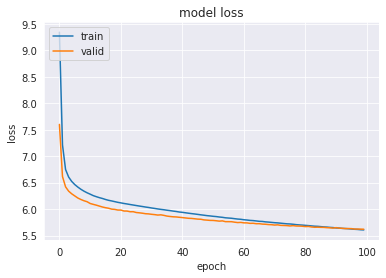

In [28]:
if samples_list == None: 
    
    results_list = Parallel(n_jobs=n_jobs, 
                            verbose=11, 
                            backend='loky')(delayed(train_nn_and_pred)(lambda_net_train_dataset,
                                                                       lambda_net_valid_dataset,
                                                                       lambda_net_test_dataset, 
                                                                       callback_names=['early_stopping']) for lambda_net_train_dataset,
                                                                                                              lambda_net_valid_dataset,
                                                                                                              lambda_net_test_dataset  in zip(lambda_net_train_dataset_list,
                                                                                                                                              lambda_net_valid_dataset_list,
                                                                                                                                              lambda_net_test_dataset_list))      

    history_list = [result[0] for result in results_list]
    
    scores_list = [result[1] for result in results_list]
    
    function_values_complete_list = [result[2] for result in results_list]
    function_values_valid_list = [function_values[0] for function_values in function_values_complete_list]
    function_values_test_list = [function_values[1] for function_values in function_values_complete_list]

    inet_preds_list = [result[3] for result in results_list]
    inet_preds_valid_list = [inet_preds[0] for inet_preds in inet_preds_list]
    inet_preds_test_list = [inet_preds[1] for inet_preds in inet_preds_list]
    
    distrib_dict_list = [result[4] for result in results_list]

    for i, history in enumerate(history_list):  
        index = (i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1
        
        plt.plot(history[list(history.keys())[1]])
        if consider_labels_training or evaluate_with_real_function:
            plt.plot(history[list(history.keys())[len(history.keys())//2+1]])
        plt.title('model ' + list(history.keys())[len(history.keys())//2+1])
        plt.ylabel('metric')
        plt.xlabel('epoch')
        plt.legend(['train', 'valid'], loc='upper left')
        plt.savefig('./data/results/' + interpretation_network_string + filename + '/' + list(history.keys())[len(history.keys())//2+1] +  '_' + interpretation_network_string + filename + '_epoch_' + str(index).zfill(3) + '.png')
        plt.clf()
        
        plt.plot(history['loss'])
        if consider_labels_training or evaluate_with_real_function:
            plt.plot(history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'valid'], loc='upper left')
        plt.savefig('./data/results/' + interpretation_network_string + filename + '/loss_' + interpretation_network_string + filename + '_epoch_' + str(index).zfill(3) + '.png')    
        if i < len(history_list)-1:
            plt.clf()
   
    path = './data/results/' + interpretation_network_string + filename + '/history_' + interpretation_network_string + filename + '.pkl'
    with open(path, 'wb') as f:
        pickle.dump(history_list, f, protocol=2)   
        
    path = './data/results/' + interpretation_network_string + filename + '/history_' + interpretation_network_string + filename + '.pkl'
    with open(path, 'wb') as f:
        pickle.dump(scores_list, f, protocol=2)   
        
else:
    
    results_list = Parallel(n_jobs=n_jobs, verbose=11, backend='loky')(delayed(train_nn_and_pred)(lambda_net_train_dataset.sample(samples),
                                                                                                  lambda_net_valid_dataset,
                                                                                                  lambda_net_test_dataset, 
                                                                                                  callback_names=['early_stopping']) for samples in samples_list)     
    
    history_list = [result[0] for result in results_list]
    
    scores_list = [result[1] for result in results_list]
    
    function_values_complete_list = [result[2] for result in results_list]
    function_values_valid_list = [function_values[0] for function_values in function_values_complete_list]
    function_values_test_list = [function_values[1] for function_values in function_values_complete_list]

    inet_preds_list = [result[3] for result in results_list]
    inet_preds_valid_list = [inet_preds[0] for inet_preds in inet_preds_list]
    inet_preds_test_list = [inet_preds[1] for inet_preds in inet_preds_list]

    
    distrib_dict_list = [result[4] for result in results_list]
    
    for i, history in enumerate(history_list):       
        
        plt.plot(history[list(history.keys())[len(history.keys())//2+1]])
        if consider_labels_training or evaluate_with_real_function:
            plt.plot(history[list(history.keys())[1]])
        plt.title('model ' + list(history.keys())[len(history.keys())//2+1])
        plt.ylabel('metric')
        plt.xlabel('epoch')
        plt.legend(['train', 'valid'], loc='upper left')
        plt.savefig('./data/results/' + interpretation_network_string + filename + '/' + list(history.keys())[len(history.keys())//2+1] +  '_' + interpretation_network_string + filename + '_epoch_' + str(samples_list[i]).zfill(5) + '.png')
        plt.clf()
        
        plt.plot(history['loss'])
        if consider_labels_training or evaluate_with_real_function:
            plt.plot(history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'valid'], loc='upper left')
        plt.savefig('./data/results/' + interpretation_network_string + filename + '/loss_' + interpretation_network_string + filename + '_epoch_' + str(samples_list[i]).zfill(5) + '.png')    
        if i < len(history_list)-1:
            plt.clf()
    
    path = './data/results/' + interpretation_network_string + filename + '/history_' + interpretation_network_string + filename + '.pkl'
    with open(path, 'wb') as f:
        pickle.dump(history_list, f, protocol=2)   
        
    path = './data/results/' + interpretation_network_string + filename + '/history_' + interpretation_network_string + filename + '.pkl'
    with open(path, 'wb') as f:
        pickle.dump(scores_list, f, protocol=2)     
        

## Evaluate Interpretation Net

In [29]:
scores_list[-1]

MAE  RMSE   MAPE  Accuracy  \
inetPoly_VS_targetPoly_valid     3.605 4.545 37.818     0.000   
inetPoly_VS_targetPoly_test      3.608 4.548 17.252     0.000   
inetPoly_VS_predLambda_valid       NaN   NaN    NaN       NaN   
inetPoly_VS_predLambda_test        NaN   NaN    NaN       NaN   
inetPoly_VS_lstsqTarget_valid    3.605 4.545 37.818     0.000   
inetPoly_VS_lstsqTarget_test     3.608 4.548 17.252     0.000   
inetPoly_VS_lstsqLambda_valid    1.601 2.057 10.185     0.000   
inetPoly_VS_lstsqLambda_test     1.604 2.062  4.992     0.000   
lstsqLambda_VS_predLambda_valid    NaN   NaN    NaN       NaN   
lstsqLambda_VS_predLambda_test     NaN   NaN    NaN       NaN   
lstsqLambda_VS_lstsqTarget_valid 3.078 3.911 15.085     0.000   
lstsqLambda_VS_lstsqTarget_test  3.079 3.912 21.625     0.000   
lstsqLambda_VS_targetPoly_valid  3.078 3.911 15.085     0.000   
lstsqLambda_VS_targetPoly_test   3.079 3.912 21.625     0.000   
predLambda_VS_lstsqTarget_valid    NaN   NaN    NaN       NaN   
predLambda_VS_lstsqTarget_test     NaN   NaN    NaN       NaN   
predLambda_VS_targetPoly_valid     NaN   NaN    NaN       NaN   
predLambda_VS_targetPoly_test      NaN   NaN    NaN       NaN   
lstsqTarget_VS_targetPoly_valid  0.000 0.000    NaN     1.000   
lstsqTarget_VS_targetPoly_test   0.000 0.000    NaN     1.000   

                                  Accuracy Multilabel  MAE FV  RMSE FV  \
inetPoly_VS_targetPoly_valid                    0.000   5.837    7.912   
inetPoly_VS_targetPoly_test                     0.000   5.841    7.917   
inetPoly_VS_predLambda_valid                      NaN   3.241    4.197   
inetPoly_VS_predLambda_test                       NaN   3.258    4.219   
inetPoly_VS_lstsqTarget_valid                   0.000   5.837    7.912   
inetPoly_VS_lstsqTarget_test                    0.000   5.841    7.917   
inetPoly_VS_lstsqLambda_valid                   0.000   3.067    4.049   
inetPoly_VS_lstsqLambda_test                    0.000   3.078    4.064   
lstsqLambda_VS_predLambda_valid                   NaN   1.283    1.728   
lstsqLambda_VS_predLambda_test                    NaN   1.285    1.730   
lstsqLambda_VS_lstsqTarget_valid                0.000   4.624    6.342   
lstsqLambda_VS_lstsqTarget_test                 0.000   4.623    6.341   
lstsqLambda_VS_targetPoly_valid                 0.000   4.624    6.342   
lstsqLambda_VS_targetPoly_test                  0.000   4.623    6.341   
predLambda_VS_lstsqTarget_valid                   NaN   4.956    6.931   
predLambda_VS_lstsqTarget_test                    NaN   4.954    6.930   
predLambda_VS_targetPoly_valid                    NaN   4.956    6.931   
predLambda_VS_targetPoly_test                     NaN   4.954    6.930   
lstsqTarget_VS_targetPoly_valid                 1.000   0.000    0.000   
lstsqTarget_VS_targetPoly_test                  1.000   0.000    0.000   

                                  MAPE FV  R2 FV  RAAE FV  RMAE FV  \
inetPoly_VS_targetPoly_valid        4.359  0.622    0.446    2.181   
inetPoly_VS_targetPoly_test         3.898  0.624    0.445    2.174   
inetPoly_VS_predLambda_valid        2.387  0.896    0.246    1.065   
inetPoly_VS_predLambda_test         2.250  0.896    0.246    1.066   
inetPoly_VS_lstsqTarget_valid       4.359  0.622    0.446    2.181   
inetPoly_VS_lstsqTarget_test        3.898  0.624    0.445    2.174   
inetPoly_VS_lstsqLambda_valid       2.145  0.903    0.233    1.083   
inetPoly_VS_lstsqLambda_test        2.200  0.903    0.233    1.088   
lstsqLambda_VS_predLambda_valid     1.017  0.982    0.098    0.528   
lstsqLambda_VS_predLambda_test      0.888  0.982    0.097    0.524   
lstsqLambda_VS_lstsqTarget_valid    3.256  0.760    0.351    1.782   
lstsqLambda_VS_lstsqTarget_test     3.260  0.761    0.350    1.775   
lstsqLambda_VS_targetPoly_valid     3.256  0.760    0.351    1.782   
lstsqLambda_VS_targetPoly_test      3.260  0.761    0.350    1.775   
predLambda_VS_lstsqTarget_valid     4.022  0.710    0.379    2.0

In [30]:
distrib_dict_list[-1]['MAE']

L-0   L-1   L-2   L-3   L-4   L-5   L-6  \
inetPoly_VS_targetPoly_valid     5.417 6.098 6.244 6.482 6.009 6.020 5.804   
inetPoly_VS_targetPoly_test      6.263 5.431 6.373 5.601 7.202 7.037 5.736   
inetPoly_VS_predLambda_valid     3.684 3.749 3.304 3.550 2.814 2.072 2.888   
inetPoly_VS_predLambda_test      3.217 2.428 2.630 3.322 3.412 3.653 3.858   
inetPoly_VS_lstsqTarget_valid    5.417 6.098 6.244 6.482 6.009 6.020 5.804   
inetPoly_VS_lstsqTarget_test     6.263 5.431 6.373 5.601 7.202 7.037 5.736   
inetPoly_VS_lstsqLambda_valid    3.438 3.437 3.386 3.185 2.733 1.990 2.701   
inetPoly_VS_lstsqLambda_test     2.889 2.294 2.339 2.866 3.436 3.690 3.827   
lstsqLambda_VS_predLambda_valid  1.121 1.244 1.361 1.563 1.060 0.874 1.072   
lstsqLambda_VS_predLambda_test   1.313 1.065 1.331 1.513 1.230 1.214 1.478   
lstsqLambda_VS_lstsqTarget_valid 3.798 4.905 4.814 4.997 5.139 5.368 4.185   
lstsqLambda_VS_lstsqTarget_test  5.109 4.542 5.794 4.225 4.947 5.116 3.929   
lstsqLambda_VS_targetPoly_valid  3.798 4.905 4.814 4.997 5.139 5.368 4.185   
lstsqLambda_VS_targetPoly_test   5.109 4.542 5.794 4.225 4.947 5.116 3.929   
predLambda_VS_lstsqTarget_valid  4.054 5.269 5.102 5.545 5.216 5.598 4.504   
predLambda_VS_lstsqTarget_test   5.379 5.018 6.143 4.704 5.293 5.525 4.409   
predLambda_VS_targetPoly_valid   4.054 5.269 5.102 5.545 5.216 5.598 4.504   
predLambda_VS_targetPoly_test    5.379 5.018 6.143 4.704 5.293 5.525 4.409   
lstsqTarget_VS_targetPoly_valid  0.000 0.000 0.000 0.000 0.000 0.000 0.000   
lstsqTarget_VS_targetPoly_test   0.000 0.000 0.000 0.000 0.000 0.000 0.000   

                                   L-7   L-8   L-9  L-10  L-11  L-12  L-13  \
inetPoly_VS_targetPoly_valid     4.997 5.329 5.825 5.305 5.542 5.880 5.754   
inetPoly_VS_targetPoly_test      5.736 6.540 5.944 5.434 5.769 6.311 5.036   
inetPoly_VS_predLambda_valid     2.627 2.998 3.640 2.559 3.546 3.247 2.738   
inetPoly_VS_predLambda_test      2.809 3.184 3.699 3.104 3.069 3.041 2.860   
inetPoly_VS_lstsqTarget_valid    4.997 5.329 5.825 5.305 5.542 5.880 5.754   
inetPoly_VS_lstsqTarget_test     5.736 6.540 5.944 5.434 5.769 6.311 5.036   
inetPoly_VS_lstsqLambda_valid    2.450 2.735 3.357 2.282 3.460 3.014 2.596   
inetPoly_VS_lstsqLambda_test     2.770 3.136 3.508 2.832 2.858 3.097 2.464   
lstsqLambda_VS_predLambda_valid  1.327 1.277 1.392 1.113 1.211 1.048 1.345   
lstsqLambda_VS_predLambda_test   1.338 1.117 1.478 1.139 1.156 1.109 1.244   
lstsqLambda_VS_lstsqTarget_valid 3.880 3.886 5.011 4.579 4.232 5.782 4.468   
lstsqLambda_VS_lstsqTarget_test  4.288 5.515 4.336 3.977 4.175 4.848 4.309   
lstsqLambda_VS_targetPoly_valid  3.880 3.886 5.011 4.579 4.232 5.782 4.468   
lstsqLambda_VS_targetPoly_test   4.288 5.515 4.336 3.977 4.175 4.848 4.309   
predLambda_VS_lstsqTarget_valid  4.308 4.371 5.323 4.838 4.621 5.983 4.647   
predLambda_VS_lstsqTarget_test   4.937 5.818 4.835 4.083 4.565 5.161 4.639   
predLambda_VS_targetPoly_valid   4.308 4.371 5.323 4.838 4.621 5.983 4.647   
predLambda_VS_targetPoly_test    4.937 5.818 4.835 4.083 4.565 5.161 4.639   
lstsqTarget_VS_targetPoly_valid  0.000 0.000 0.000 0.000 0.000 0.000 0.000   
lstsqTarget_VS_targetPoly_test   0.000 0.000 0.000 0.000 0.000 0.000 0.000   

                                  L-14  L-15  L-16  L-17  L-18  L-19  L-20  \
inetPoly_VS_targetPoly_valid     5.774 6.137 5.603 5.216 6.428 5.468 5.348   
inetPoly_VS_targetPoly_test      5.303 5.521 5.351 6.039 5.099 7.071 5.780   
inetPoly_VS_predLambda_valid     2.806 2.603 2.395 2.870 3.282 3.144 2.798   
inetPoly_VS_predLambda_test      2.467 3.253 2.896 3.513 2.633 3.478 3.011   
inetPoly_VS_lstsqTarget_valid    5.774 6.137 5.603 5.216 6.428 5.468 5.348   
inetPoly_VS_lstsqTarget_test     5.303 5.521 5.351 6.039 5.099 7.071 5.780   
inetPoly_VS_lstsqLambda_valid    2.264 2.478 2.538 2.678 2.966 3.149 2.455   
inetPoly_VS_lstsqLambda_test     2.519 3.320 2.807 3.379 2.365 3.279 2.786   
lstsqLambda_VS_predLambda_valid  1.270 1.303 1.056 1.08

In [31]:
distrib_dict_list[-1]['R2']

L-0   L-1   L-2   L-3   L-4   L-5   L-6  \
inetPoly_VS_targetPoly_valid     0.647 0.624 0.404 0.556 0.659 0.480 0.491   
inetPoly_VS_targetPoly_test      0.555 0.377 0.228 0.550 0.528 0.565 0.741   
inetPoly_VS_predLambda_valid     0.854 0.863 0.848 0.883 0.937 0.930 0.901   
inetPoly_VS_predLambda_test      0.906 0.881 0.904 0.869 0.895 0.878 0.892   
inetPoly_VS_lstsqTarget_valid    0.647 0.624 0.404 0.556 0.659 0.480 0.491   
inetPoly_VS_lstsqTarget_test     0.555 0.377 0.228 0.550 0.528 0.565 0.741   
inetPoly_VS_lstsqLambda_valid    0.872 0.886 0.833 0.904 0.938 0.935 0.904   
inetPoly_VS_lstsqLambda_test     0.914 0.893 0.912 0.892 0.896 0.868 0.890   
lstsqLambda_VS_predLambda_valid  0.980 0.976 0.976 0.977 0.991 0.988 0.988   
lstsqLambda_VS_predLambda_test   0.982 0.974 0.975 0.977 0.983 0.977 0.982   
lstsqLambda_VS_lstsqTarget_valid 0.733 0.713 0.691 0.722 0.791 0.532 0.794   
lstsqLambda_VS_lstsqTarget_test  0.669 0.480 0.446 0.782 0.712 0.669 0.878   
lstsqLambda_VS_targetPoly_valid  0.733 0.713 0.691 0.722 0.791 0.532 0.794   
lstsqLambda_VS_targetPoly_test   0.669 0.480 0.446 0.782 0.712 0.669 0.878   
predLambda_VS_lstsqTarget_valid  0.679 0.588 0.641 0.663 0.778 0.484 0.730   
predLambda_VS_lstsqTarget_test   0.632 0.349 0.349 0.747 0.657 0.578 0.829   
predLambda_VS_targetPoly_valid   0.679 0.588 0.641 0.663 0.778 0.484 0.730   
predLambda_VS_targetPoly_test    0.632 0.349 0.349 0.747 0.657 0.578 0.829   
lstsqTarget_VS_targetPoly_valid  1.000 1.000 1.000 1.000 1.000 1.000 1.000   
lstsqTarget_VS_targetPoly_test   1.000 1.000 1.000 1.000 1.000 1.000 1.000   

                                   L-7   L-8   L-9  L-10  L-11  L-12  L-13  \
inetPoly_VS_targetPoly_valid     0.711 0.685 0.660 0.529 0.661 0.782 0.486   
inetPoly_VS_targetPoly_test      0.627 0.613 0.625 0.771 0.493 0.384 0.716   
inetPoly_VS_predLambda_valid     0.927 0.907 0.884 0.902 0.868 0.925 0.888   
inetPoly_VS_predLambda_test      0.920 0.923 0.880 0.938 0.863 0.876 0.924   
inetPoly_VS_lstsqTarget_valid    0.711 0.685 0.660 0.529 0.661 0.782 0.486   
inetPoly_VS_lstsqTarget_test     0.627 0.613 0.625 0.771 0.493 0.384 0.716   
inetPoly_VS_lstsqLambda_valid    0.931 0.913 0.905 0.916 0.875 0.937 0.894   
inetPoly_VS_lstsqLambda_test     0.915 0.923 0.877 0.944 0.874 0.868 0.939   
lstsqLambda_VS_predLambda_valid  0.982 0.979 0.983 0.981 0.981 0.992 0.971   
lstsqLambda_VS_predLambda_test   0.980 0.988 0.978 0.992 0.977 0.983 0.985   
lstsqLambda_VS_lstsqTarget_valid 0.819 0.809 0.744 0.643 0.776 0.758 0.681   
lstsqLambda_VS_lstsqTarget_test  0.796 0.752 0.788 0.886 0.746 0.653 0.793   
lstsqLambda_VS_targetPoly_valid  0.819 0.809 0.744 0.643 0.776 0.758 0.681   
lstsqLambda_VS_targetPoly_test   0.796 0.752 0.788 0.886 0.746 0.653 0.793   
predLambda_VS_lstsqTarget_valid  0.780 0.760 0.696 0.589 0.723 0.744 0.641   
predLambda_VS_lstsqTarget_test   0.725 0.700 0.723 0.881 0.662 0.585 0.759   
predLambda_VS_targetPoly_valid   0.780 0.760 0.696 0.589 0.723 0.744 0.641   
predLambda_VS_targetPoly_test    0.725 0.700 0.723 0.881 0.662 0.585 0.759   
lstsqTarget_VS_targetPoly_valid  1.000 1.000 1.000 1.000 1.000 1.000 1.000   
lstsqTarget_VS_targetPoly_test   1.000 1.000 1.000 1.000 1.000 1.000 1.000   

                                  L-14  L-15  L-16  L-17  L-18  L-19  L-20  \
inetPoly_VS_targetPoly_valid     0.497 0.337 0.614 0.668 0.772 0.699 0.393   
inetPoly_VS_targetPoly_test      0.684 0.768 0.709 0.666 0.663 0.503 0.586   
inetPoly_VS_predLambda_valid     0.900 0.885 0.921 0.910 0.935 0.897 0.842   
inetPoly_VS_predLambda_test      0.945 0.923 0.917 0.900 0.919 0.903 0.908   
inetPoly_VS_lstsqTarget_valid    0.497 0.337 0.614 0.668 0.772 0.699 0.393   
inetPoly_VS_lstsqTarget_test     0.684 0.768 0.709 0.666 0.663 0.503 0.586   
inetPoly_VS_lstsqLambda_valid    0.932 0.898 0.915 0.917 0.946 0.899 0.867   
inetPoly_VS_lstsqLambda_test     0.942 0.924 0.922 0.898 0.932 0.913 0.920   
lstsqLambda_VS_predLambda_valid  0.979 0.970 0.985 0.98

In [33]:
index_min = int(np.argmin(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
polynomial_inet = inet_preds_test_list[-1][index_min]

print(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][index_min])

print_polynomial_from_coefficients(polynomial_inet)

-0.3400963073886045


<IPython.core.display.Math object>

In [34]:
index_min = int(np.argmin(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial

print(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][index_min])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_lambda)

0.016677783348599706


<IPython.core.display.Math object>

In [35]:
index_min = int(np.argmin(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial
polynomial_target = lambda_net_test_dataset.target_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_target)

<IPython.core.display.Math object>

In [36]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
polynomial_inet = inet_preds_test_list[-1][index_max]

print(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][index_max])

print_polynomial_from_coefficients(polynomial_inet)

0.7786657453063591


<IPython.core.display.Math object>

In [37]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial

print(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][index_max])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_max]
print_polynomial_from_coefficients(polynomial_lambda)

0.9286390011486833


<IPython.core.display.Math object>

In [38]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial
polynomial_target = lambda_net_test_dataset.target_polynomial_list[index_max]
print_polynomial_from_coefficients(polynomial_target)

<IPython.core.display.Math object>

In [39]:
r2_values_inet = distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test']
print('Mean: ' + str(np.mean(r2_values_inet)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_inet = r2_values_inet[r2_values_inet>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_inet)) + ' (' + str(r2_values_positive_inet.shape[0]) + ' Samples)')



Mean: 0.6242573732734145 (10000 Samples)
Mean (only positive): 0.6259395615938802 (9977 Samples)


In [40]:
r2_values_lstsq_lambda = distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test']
print('Mean: ' + str(np.mean(r2_values_lstsq_lambda)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_lstsq_lambda = r2_values_lstsq_lambda[r2_values_lstsq_lambda>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_lstsq_lambda)) + ' (' + str(r2_values_positive_lstsq_lambda.shape[0]) + ' Samples)')



Mean: 0.7611785328716952 (10000 Samples)
Mean (only positive): 0.7611785328716952 (10000 Samples)


<AxesSubplot:xlabel='inetPoly_VS_targetPoly_test', ylabel='Count'>

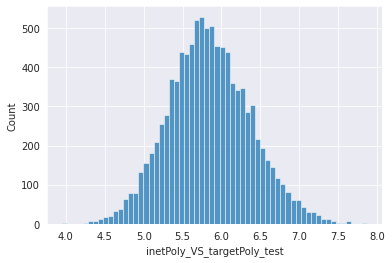

In [41]:
sns.histplot(distrib_dict_list[-1]['MAE'].loc['inetPoly_VS_targetPoly_test'])


<AxesSubplot:xlabel='lstsqLambda_VS_targetPoly_test', ylabel='Count'>

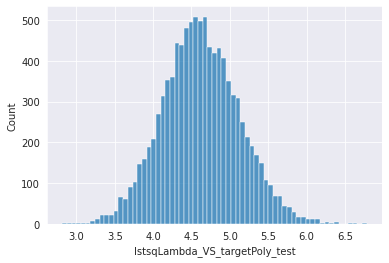

In [42]:
sns.histplot(distrib_dict_list[-1]['MAE'].loc['lstsqLambda_VS_targetPoly_test'])


[(-30.0, 1.0)]

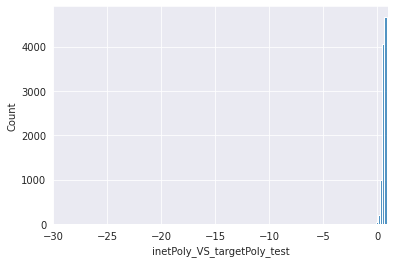

In [43]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'], binwidth=0.2)
p.set(xlim=(-30, 1))

[(0.0, 1.0)]

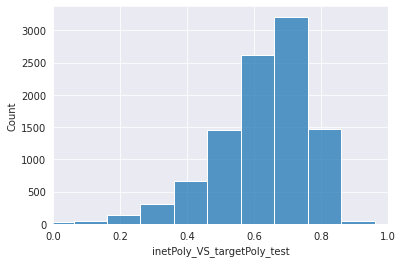

In [44]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'], binwidth=0.1)
p.set(xlim=(0, 1))

[(-10.0, 1.0)]

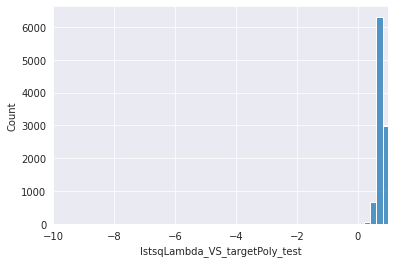

In [45]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'], binwidth=0.2)
p.set(xlim=(-10, 1))

[(0.0, 1.0)]

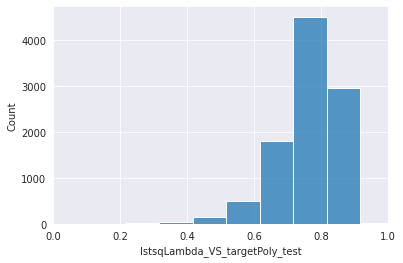

In [46]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'], binwidth=0.1)
p.set(xlim=(0, 1))

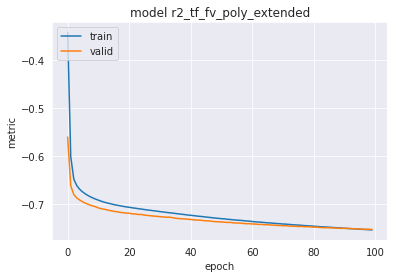

In [47]:
plt.plot(history[list(history.keys())[1]])
if consider_labels_training or evaluate_with_real_function:
    plt.plot(history[list(history.keys())[len(history.keys())//2+1]]) 
plt.title('model ' + list(history.keys())[1])
plt.ylabel('metric')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig('./data/results/' + interpretation_network_string + filename + '/metric_' + interpretation_network_string + filename + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')


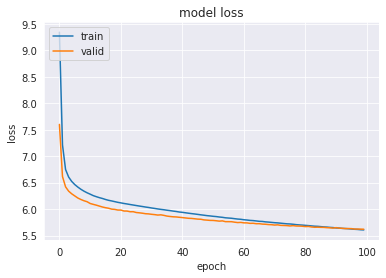

In [48]:
plt.plot(history['loss'])
if consider_labels_training or evaluate_with_real_function:
    plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig('./data/results/' + interpretation_network_string + filename + '/loss_' + interpretation_network_string + filename + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')    


### Multi Epoch/Sampes Analysis

### Generate Comparison Plots

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

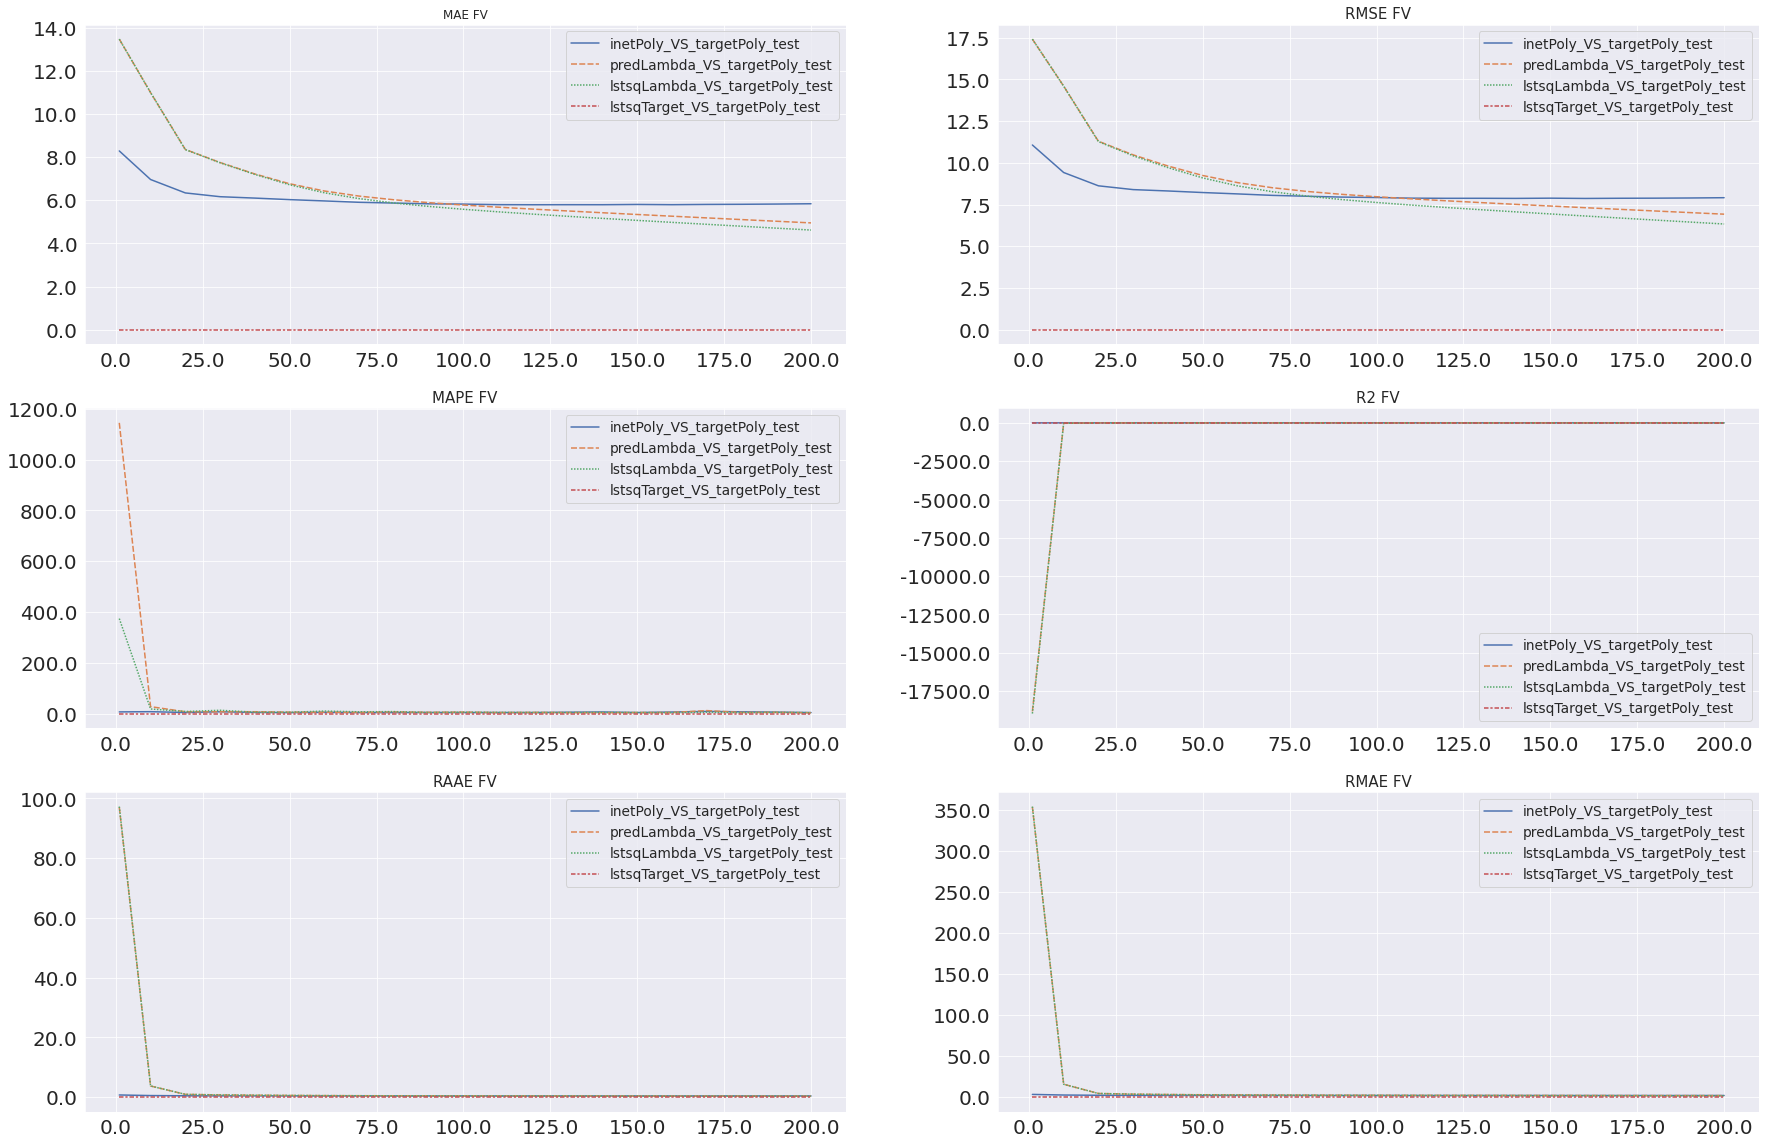

In [49]:
#Generate plot TEST PRED
plot_metric_list = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV']

if samples_list == None:
    x_axis_steps = [(i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1 for i in epochs_save_range_lambda]
    x_max = epochs_lambda
else:
    x_axis_steps = samples_list
    x_max = samples_list[-1]
    
if evaluate_with_real_function:
    #Plot Polynom, lamdba net, and Interpration net
    length_plt = len(plot_metric_list)
    fig, ax = plt.subplots(length_plt//2, 2, figsize=(30,20))
    for index, metric in enumerate(plot_metric_list):

        inetPoly_VS_targetPoly_test = []
        #inetPoly_VS_predLambda_test = []
        #inetPoly_VS_lstsqTarget_test = []
        #inetPoly_VS_lstsqLambda_test = []
        #lstsqLambda_VS_predLambda_test = []
        #lstsqLambda_VS_lstsqTarget_test = []
        lstsqLambda_VS_targetPoly_test = []
        #predLambda_VS_lstsqTarget_test = []
        predLambda_VS_targetPoly_test = []
        lstsqTarget_VS_targetPoly_test = []

        for scores in scores_list:
            inetPoly_VS_targetPoly_test.append(scores[metric].loc['inetPoly_VS_targetPoly_test'])
            predLambda_VS_targetPoly_test.append(scores[metric].loc['predLambda_VS_targetPoly_test'])
            lstsqLambda_VS_targetPoly_test.append(scores[metric].loc['lstsqLambda_VS_targetPoly_test'])     
            lstsqTarget_VS_targetPoly_test.append(scores[metric].loc['lstsqTarget_VS_targetPoly_test'])
        
        plot_df = pd.DataFrame(data=np.vstack([inetPoly_VS_targetPoly_test, predLambda_VS_targetPoly_test, lstsqLambda_VS_targetPoly_test, lstsqTarget_VS_targetPoly_test]).T, 
                               index=x_axis_steps,
                               columns=['inetPoly_VS_targetPoly_test', 'predLambda_VS_targetPoly_test', 'lstsqLambda_VS_targetPoly_test', 'lstsqTarget_VS_targetPoly_test'])

        ax[index//2, index%2].set_title(metric)
        sns.set(font_scale = 1.25)
        p = sns.lineplot(data=plot_df, ax=ax[index//2, index%2])
        p.set_yticklabels(p.get_yticks(), size = 20)
        p.set_xticklabels(p.get_xticks(), size = 20)        
    
    location = './data/plotting/'
    folder = interpretation_network_string + filename + '/'
    if samples_list == None:
        file = 'multi_epoch_REAL_' + interpretation_network_string+  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    else:
        file = 'sample_list' + '-'.join([str(samples_list[0]), str(samples_list[-1])]) +'_REAL_' + interpretation_network_string +  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    
    path = location + folder + file
    
    plt.savefig(path, format='eps')
    plt.show()
    
else:
    #Plot Polynom, lamdba net, and Interpration net
    length_plt = len(plot_metric_list)
    fig, ax = plt.subplots(length_plt//2, 2, figsize=(30,20))
    for index, metric in enumerate(plot_metric_list):

        #inetPoly_VS_targetPoly_test = []
        inetPoly_VS_predLambda_test = []
        #inetPoly_VS_lstsqTarget_test = []
        inetPoly_VS_lstsqLambda_test = []
        lstsqLambda_VS_predLambda_test = []
        #lstsqLambda_VS_lstsqTarget_test = []
        #lstsqLambda_VS_targetPoly_test = []
        #predLambda_VS_lstsqTarget_test = []
        predLambda_VS_targetPoly_test = []
        #lstsqTarget_VS_targetPoly_test = []

        for scores in scores_list:
            inetPoly_VS_lstsqLambda_test.append(scores[metric].loc['inetPoly_VS_lstsqLambda_test'])
            inetPoly_VS_predLambda_test.append(scores[metric].loc['inetPoly_VS_predLambda_test'])
            lstsqLambda_VS_predLambda_test.append(scores[metric].loc['lstsqLambda_VS_predLambda_test'])     
            predLambda_VS_targetPoly_test.append(scores[metric].loc['predLambda_VS_targetPoly_test'])     
            
        plot_df = pd.DataFrame(data=np.vstack([inetPoly_VS_predLambda_test, inetPoly_VS_lstsqLambda_test, lstsqLambda_VS_predLambda_test, predLambda_VS_targetPoly_test]).T, 
                               index=x_axis_steps,
                               columns=['inetPoly_VS_predLambda_test', 'inetPoly_VS_lstsqLambda_test', 'lstsqLambda_VS_predLambda_test', 'predLambda_VS_targetPoly_test'])

        ax[index//2, index%2].set_title(metric)
        sns.set(font_scale = 1.25)
        p = sns.lineplot(data=plot_df, ax=ax[index//2, index%2])
        p.set_yticklabels(p.get_yticks(), size = 20)
        p.set_xticklabels(p.get_xticks(), size = 20)  

    location = './data/plotting/'
    folder = interpretation_network_string + filename + '/'
    if samples_list == None:
        file = 'multi_epoch_MODEL_' + interpretation_network_string +  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    else: 
        file = 'sample_list' + '-'.join([str(samples_list[0]), str(samples_list[-1])]) +'_MODEL_' + interpretation_network_string +  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'

    path = location + folder + file
    
    plt.savefig(path, format='eps')
    plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


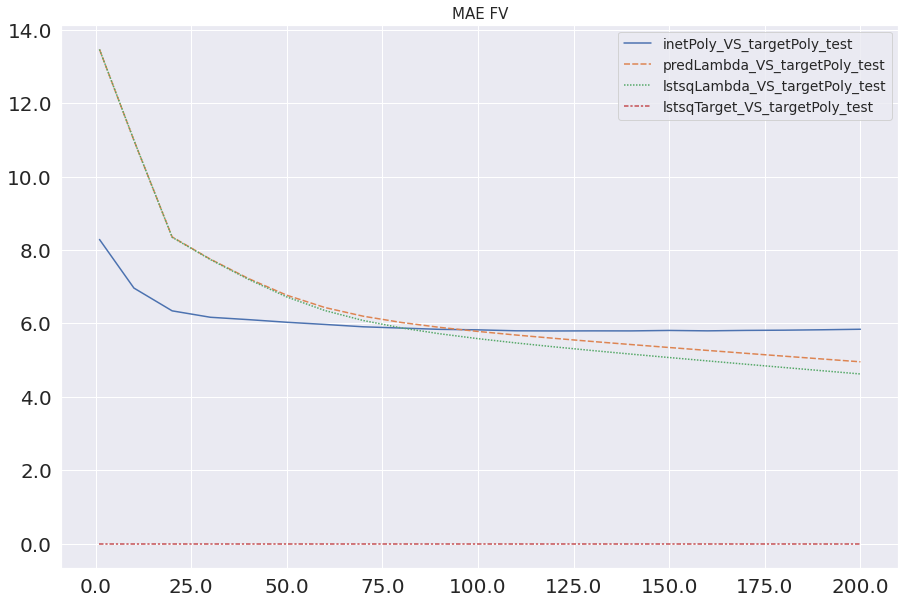

In [50]:
#Generate plot TEST PRED
plot_metric_list = ['MAE FV']

if samples_list == None:
    x_axis_steps = [(i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1 for i in epochs_save_range_lambda]
    x_max = epochs_lambda
else:
    x_axis_steps = samples_list
    x_max = samples_list[-1]
    
if evaluate_with_real_function:
    #Plot Polynom, lamdba net, and Interpration net
    length_plt = len(plot_metric_list)
    fig, ax = plt.subplots(1, 1, figsize=(15,10))
    for index, metric in enumerate(plot_metric_list):

        inetPoly_VS_targetPoly_test = []
        #inetPoly_VS_predLambda_test = []
        #inetPoly_VS_lstsqTarget_test = []
        #inetPoly_VS_lstsqLambda_test = []
        #lstsqLambda_VS_predLambda_test = []
        #lstsqLambda_VS_lstsqTarget_test = []
        lstsqLambda_VS_targetPoly_test = []
        #predLambda_VS_lstsqTarget_test = []
        predLambda_VS_targetPoly_test = []
        lstsqTarget_VS_targetPoly_test = []

        for scores in scores_list:
            inetPoly_VS_targetPoly_test.append(scores[metric].loc['inetPoly_VS_targetPoly_test'])
            predLambda_VS_targetPoly_test.append(scores[metric].loc['predLambda_VS_targetPoly_test'])
            lstsqLambda_VS_targetPoly_test.append(scores[metric].loc['lstsqLambda_VS_targetPoly_test'])     
            lstsqTarget_VS_targetPoly_test.append(scores[metric].loc['lstsqTarget_VS_targetPoly_test'])
        
        plot_df = pd.DataFrame(data=np.vstack([inetPoly_VS_targetPoly_test, predLambda_VS_targetPoly_test, lstsqLambda_VS_targetPoly_test, lstsqTarget_VS_targetPoly_test]).T, 
                               index=x_axis_steps,
                               columns=['inetPoly_VS_targetPoly_test', 'predLambda_VS_targetPoly_test', 'lstsqLambda_VS_targetPoly_test', 'lstsqTarget_VS_targetPoly_test'])

        ax.set_title(metric)
        sns.set(font_scale = 1.25)
        p = sns.lineplot(data=plot_df, ax=ax)
        p.set_yticklabels(p.get_yticks(), size = 20)
        p.set_xticklabels(p.get_xticks(), size = 20)
    
    location = './data/plotting/'
    folder = interpretation_network_string + filename + '/'
    if samples_list == None:
        file = 'multi_epoch_REAL_' + metric + interpretation_network_string+  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    else:
        file = 'sample_list' + '-'.join([str(samples_list[0]), str(samples_list[-1])]) +'_REAL_' + metric + interpretation_network_string +  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    
    path = location + folder + file
    
    plt.savefig(path, format='eps')
    plt.show()
    
else:
    #Plot Polynom, lamdba net, and Interpration net
    length_plt = len(plot_metric_list)
    fig, ax = plt.subplots(1, 1, figsize=(15,10))
    for index, metric in enumerate(plot_metric_list):

        #inetPoly_VS_targetPoly_test = []
        inetPoly_VS_predLambda_test = []
        #inetPoly_VS_lstsqTarget_test = []
        inetPoly_VS_lstsqLambda_test = []
        lstsqLambda_VS_predLambda_test = []
        #lstsqLambda_VS_lstsqTarget_test = []
        #lstsqLambda_VS_targetPoly_test = []
        #predLambda_VS_lstsqTarget_test = []
        predLambda_VS_targetPoly_test = []
        #lstsqTarget_VS_targetPoly_test = []

        for scores in scores_list:
            inetPoly_VS_lstsqLambda_test.append(scores[metric].loc['inetPoly_VS_lstsqLambda_test'])
            inetPoly_VS_predLambda_test.append(scores[metric].loc['inetPoly_VS_predLambda_test'])
            lstsqLambda_VS_predLambda_test.append(scores[metric].loc['lstsqLambda_VS_predLambda_test'])     
            predLambda_VS_targetPoly_test.append(scores[metric].loc['predLambda_VS_targetPoly_test'])     
            
        plot_df = pd.DataFrame(data=np.vstack([inetPoly_VS_predLambda_test, inetPoly_VS_lstsqLambda_test, lstsqLambda_VS_predLambda_test, predLambda_VS_targetPoly_test]).T, 
                               index=x_axis_steps,
                               columns=['inetPoly_VS_predLambda_test', 'inetPoly_VS_lstsqLambda_test', 'lstsqLambda_VS_predLambda_test', 'predLambda_VS_targetPoly_test'])

        ax.set_title(metric)
        sns.set(font_scale = 1.25)
        p = sns.lineplot(data=plot_df, ax=ax)
        p.set_yticklabels(p.get_yticks(), size = 20)
        p.set_xticklabels(p.get_xticks(), size = 20)

    location = './data/plotting/'
    folder = interpretation_network_string + filename + '/'
    if samples_list == None:
        file = 'multi_epoch_MODEL_' + metric + interpretation_network_string +  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    else: 
        file = 'sample_list' + '-'.join([str(samples_list[0]), str(samples_list[-1])]) +'_MODEL_' + metric + interpretation_network_string +  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'

    path = location + folder + file
    
    plt.savefig(path, format='eps')
    plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


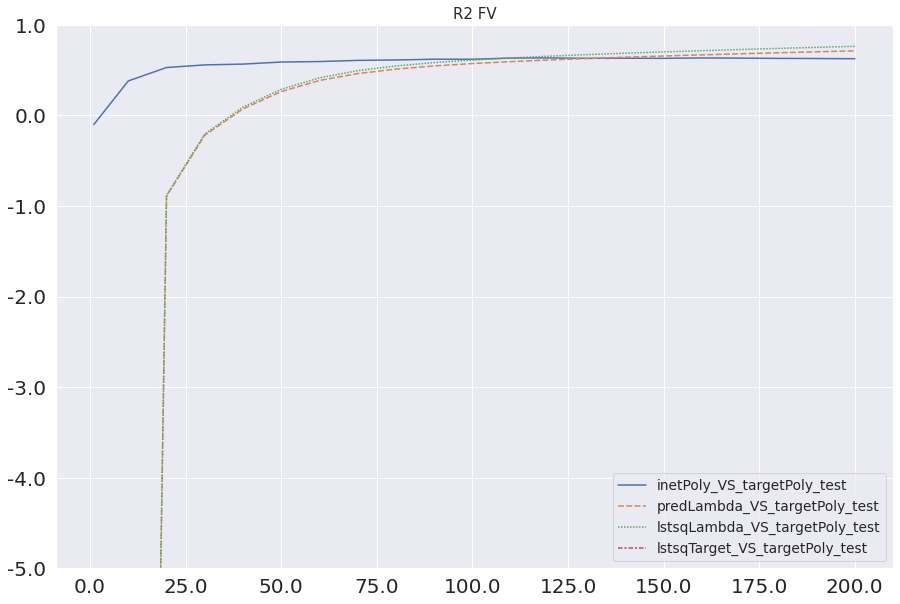

In [51]:
#Generate plot TEST PRED
plot_metric_list = ['R2 FV']

if samples_list == None:
    x_axis_steps = [(i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1 for i in epochs_save_range_lambda]
    x_max = epochs_lambda
else:
    x_axis_steps = samples_list
    x_max = samples_list[-1]
    
if evaluate_with_real_function:
    #Plot Polynom, lamdba net, and Interpration net
    length_plt = len(plot_metric_list)
    fig, ax = plt.subplots(1, 1, figsize=(15,10))
    for index, metric in enumerate(plot_metric_list):

        inetPoly_VS_targetPoly_test = []
        #inetPoly_VS_predLambda_test = []
        #inetPoly_VS_lstsqTarget_test = []
        #inetPoly_VS_lstsqLambda_test = []
        #lstsqLambda_VS_predLambda_test = []
        #lstsqLambda_VS_lstsqTarget_test = []
        lstsqLambda_VS_targetPoly_test = []
        #predLambda_VS_lstsqTarget_test = []
        predLambda_VS_targetPoly_test = []
        lstsqTarget_VS_targetPoly_test = []

        for scores in scores_list:
            inetPoly_VS_targetPoly_test.append(scores[metric].loc['inetPoly_VS_targetPoly_test'])
            predLambda_VS_targetPoly_test.append(scores[metric].loc['predLambda_VS_targetPoly_test'])
            lstsqLambda_VS_targetPoly_test.append(scores[metric].loc['lstsqLambda_VS_targetPoly_test'])     
            lstsqTarget_VS_targetPoly_test.append(scores[metric].loc['lstsqTarget_VS_targetPoly_test'])
        
        plot_df = pd.DataFrame(data=np.vstack([inetPoly_VS_targetPoly_test, predLambda_VS_targetPoly_test, lstsqLambda_VS_targetPoly_test, lstsqTarget_VS_targetPoly_test]).T, 
                               index=x_axis_steps,
                               columns=['inetPoly_VS_targetPoly_test', 'predLambda_VS_targetPoly_test', 'lstsqLambda_VS_targetPoly_test', 'lstsqTarget_VS_targetPoly_test'])

        ax.set_title(metric)
        sns.set(font_scale = 1.25)
        p = sns.lineplot(data=plot_df, ax=ax)
        p.set(ylim=(-5, 1))
        p.set_yticklabels(p.get_yticks(), size = 20)
        p.set_xticklabels(p.get_xticks(), size = 20)
    
    location = './data/plotting/'
    folder = interpretation_network_string + filename + '/'
    if samples_list == None:
        file = 'multi_epoch_REAL_' + metric + interpretation_network_string+  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    else:
        file = 'sample_list' + '-'.join([str(samples_list[0]), str(samples_list[-1])]) +'_REAL_' + metric + interpretation_network_string +  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    
    path = location + folder + file
    
    plt.savefig(path, format='eps')
    plt.show()
    
else:
    #Plot Polynom, lamdba net, and Interpration net
    length_plt = len(plot_metric_list)
    fig, ax = plt.subplots(1, 1, figsize=(15,10))
    for index, metric in enumerate(plot_metric_list):

        #inetPoly_VS_targetPoly_test = []
        inetPoly_VS_predLambda_test = []
        #inetPoly_VS_lstsqTarget_test = []
        inetPoly_VS_lstsqLambda_test = []
        lstsqLambda_VS_predLambda_test = []
        #lstsqLambda_VS_lstsqTarget_test = []
        #lstsqLambda_VS_targetPoly_test = []
        #predLambda_VS_lstsqTarget_test = []
        predLambda_VS_targetPoly_test = []
        #lstsqTarget_VS_targetPoly_test = []

        for scores in scores_list:
            inetPoly_VS_lstsqLambda_test.append(scores[metric].loc['inetPoly_VS_lstsqLambda_test'])
            inetPoly_VS_predLambda_test.append(scores[metric].loc['inetPoly_VS_predLambda_test'])
            lstsqLambda_VS_predLambda_test.append(scores[metric].loc['lstsqLambda_VS_predLambda_test'])     
            predLambda_VS_targetPoly_test.append(scores[metric].loc['predLambda_VS_targetPoly_test'])     
            
        plot_df = pd.DataFrame(data=np.vstack([inetPoly_VS_predLambda_test, inetPoly_VS_lstsqLambda_test, lstsqLambda_VS_predLambda_test, predLambda_VS_targetPoly_test]).T, 
                               index=x_axis_steps,
                               columns=['inetPoly_VS_predLambda_test', 'inetPoly_VS_lstsqLambda_test', 'lstsqLambda_VS_predLambda_test', 'predLambda_VS_targetPoly_test'])

        ax.set_title(metric)
        sns.set(font_scale = 1.25)
        p = sns.lineplot(data=plot_df, ax=ax)
        p.set(ylim=(-5, 1))
        p.set_yticklabels(p.get_yticks(), size = 20)
        p.set_xticklabels(p.get_xticks(), size = 20)

    location = './data/plotting/'
    folder = interpretation_network_string + filename + '/'
    if samples_list == None:
        file = 'multi_epoch_MODEL_' + metric + interpretation_network_string +  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    else: 
        file = 'sample_list' + '-'.join([str(samples_list[0]), str(samples_list[-1])]) +'_MODEL_' + metric + interpretation_network_string +  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'

    path = location + folder + file
    
    plt.savefig(path, format='eps')
    plt.show()


#### Generate and Analyze Predictions for Random Function

In [52]:
rand_index = 42

lambda_model_preds = function_values_test_list[-1][0][rand_index].ravel()
real_poly_fvs = function_values_test_list[-1][1][rand_index]
lstsq_lambda_preds_poly = function_values_test_list[-1][2][rand_index]
lstsq_target_poly = function_values_test_list[-1][3][rand_index]
inet_poly_fvs = function_values_test_list[-1][4][rand_index]

    
x_vars = ['x' + str(i) for i in range(1, n+1)]

columns = x_vars.copy()
columns.append('FVs')

columns_single = x_vars.copy()

eval_size_plot = inet_poly_fvs.shape[0]
vars_plot = lambda_net_test_dataset_list[-1].test_data_list[rand_index]

    
if evaluate_with_real_function:
    columns_single.extend(['Lambda Model Preds', 'Target Poly FVs', 'LSTSQ Target Poly FVs', 'I-Net Poly FVs'])
    plot_data_single = pd.DataFrame(data=np.column_stack([vars_plot, lambda_model_preds, real_poly_fvs, lstsq_target_poly, inet_poly_fvs]), columns=columns_single)
    preds_plot_all = np.vstack([lambda_model_preds, real_poly_fvs, lstsq_target_poly, inet_poly_fvs]).ravel()
    vars_plot_all_preds = np.vstack([vars_plot for i in range(len(columns_single[n:]))])
    
    lambda_model_preds_str = np.array(['Lambda Model Preds' for i in range(eval_size_plot)])
    real_poly_fvs_str = np.array(['Target Poly FVs' for i in range(eval_size_plot)])
    lstsq_target_poly_str = np.array(['LSTSQ Target Poly FVs' for i in range(eval_size_plot)])
    inet_poly_fvs_str = np.array(['I-Net Poly FVs' for i in range(eval_size_plot)])
    
    identifier = np.concatenate([lambda_model_preds_str, real_poly_fvs_str, lstsq_target_poly_str, inet_poly_fvs_str])
else:
    columns_single.extend(['Lambda Model Preds', 'Target Poly FVs', 'LSTSQ Lambda Poly FVs', 'I-Net Poly FVs'])
    plot_data_single = pd.DataFrame(data=np.column_stack([vars_plot, lambda_model_preds, real_poly_fvs, lstsq_lambda_preds_poly, inet_poly_fvs]), columns=columns_single)
    preds_plot_all = np.vstack([lambda_model_preds, real_poly_fvs, lstsq_lambda_preds_poly, inet_poly_fvs]).ravel()
    vars_plot_all_preds = np.vstack([vars_plot for i in range(len(columns_single[n:]))])
    
    lambda_model_preds_str = np.array(['Lambda Model Preds' for i in range(eval_size_plot)])
    real_poly_fvs_str = np.array(['Target Poly FVs' for i in range(eval_size_plot)])
    lstsq_lambda_preds_poly_str = np.array(['LSTSQ Lambda Poly FVs' for i in range(eval_size_plot)])
    inet_poly_fvs_str = np.array(['I-Net Poly FVs' for i in range(eval_size_plot)])
    
    identifier = np.concatenate([lambda_model_preds_str, real_poly_fvs_str, lstsq_lambda_preds_poly_str, inet_poly_fvs_str])

plot_data = pd.DataFrame(data=np.column_stack([vars_plot_all_preds, preds_plot_all]), columns=columns)
plot_data['Identifier'] = identifier



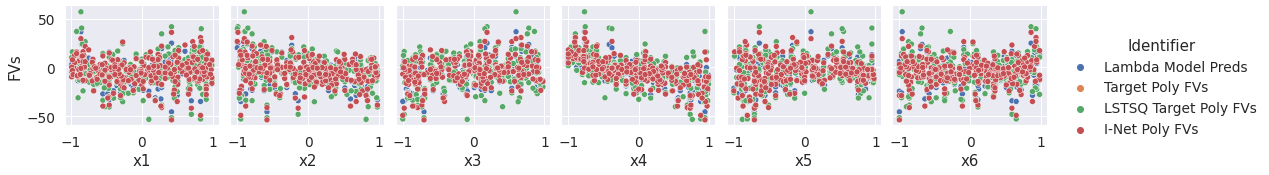

In [53]:
pp1 = sns.pairplot(data=plot_data,
                  #kind='reg',
                  hue='Identifier',
                  y_vars=['FVs'],
                  x_vars=x_vars)

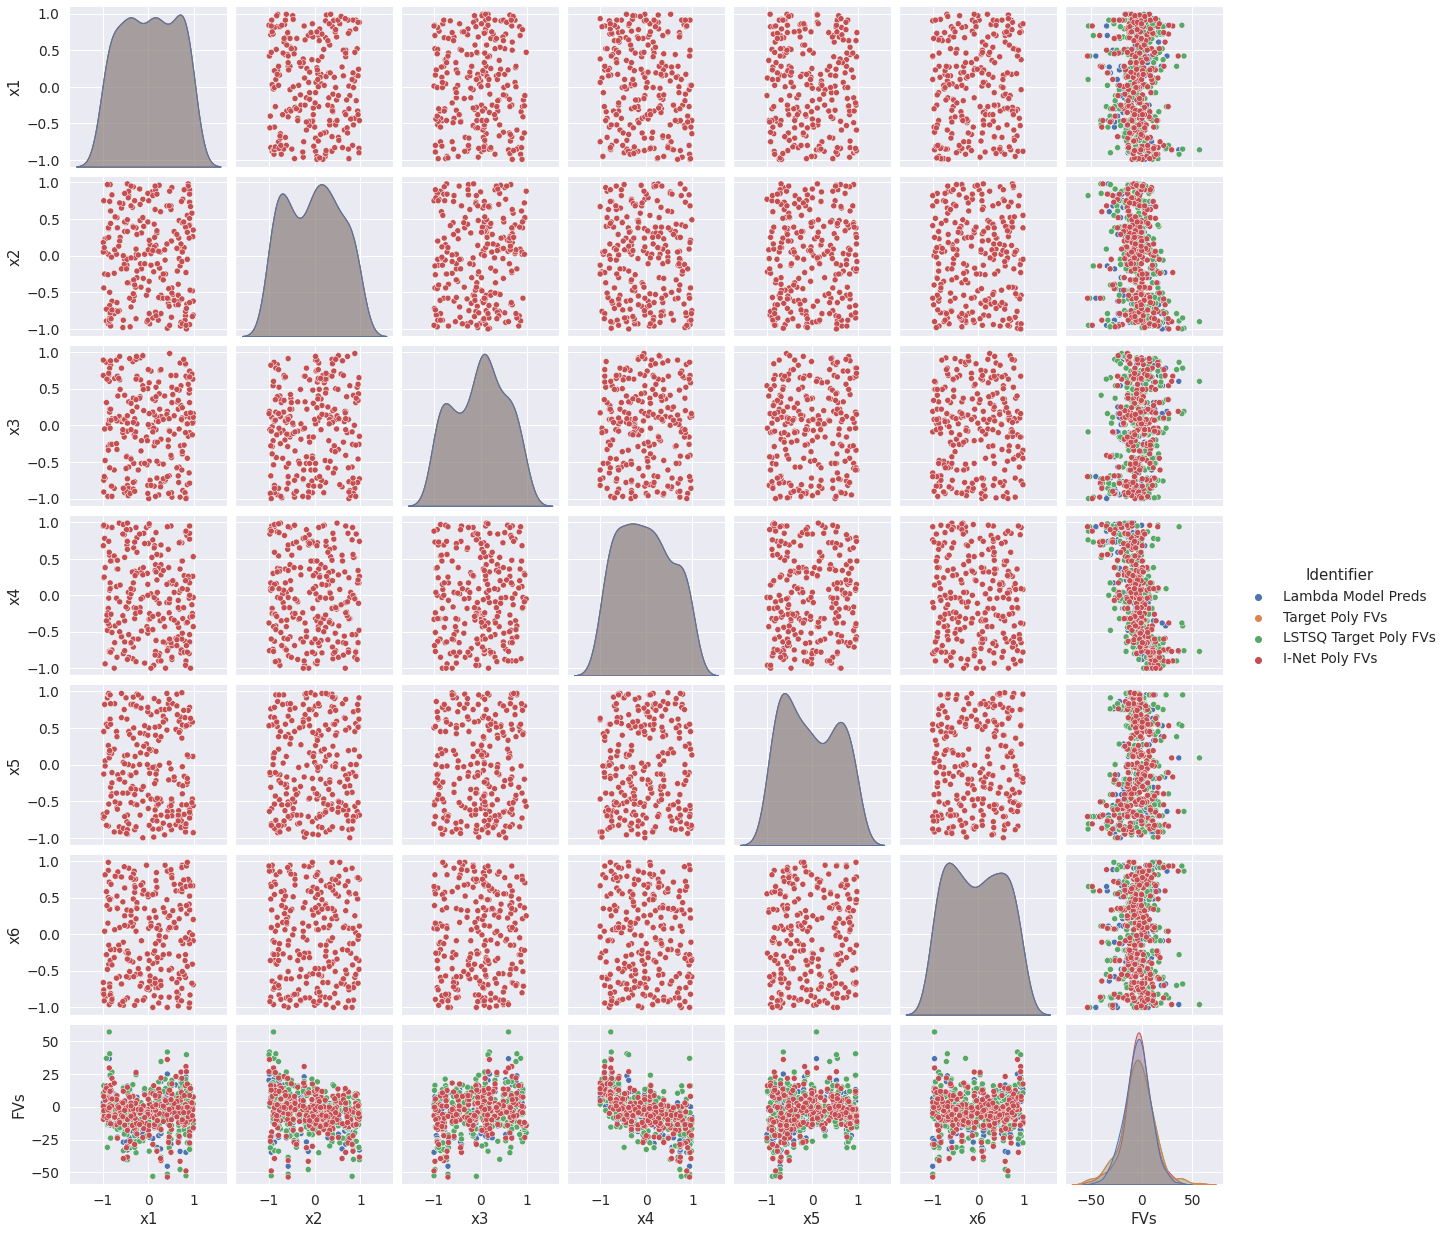

In [54]:
pp2 = sns.pairplot(data=plot_data,
                  #kind='reg',
                  hue='Identifier',
                  #y_vars=['FVs'],
                  #x_vars=x_vars
                 )

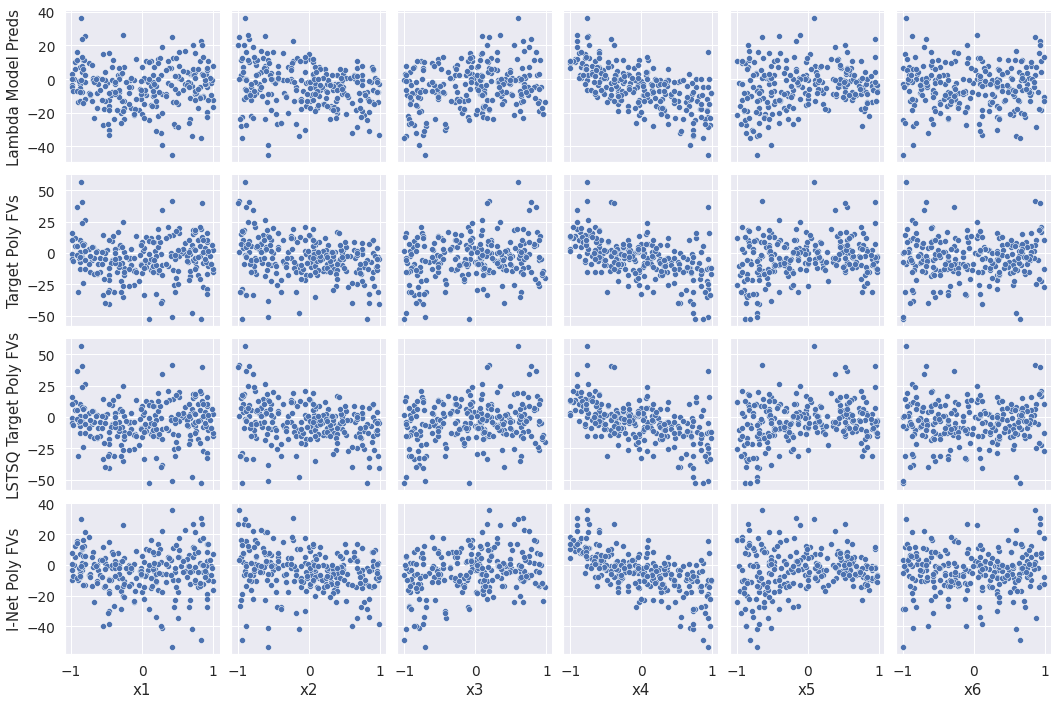

In [55]:
pp3 = sns.pairplot(data=plot_data_single,
                  #kind='reg',
                  y_vars=columns_single[n:],
                  x_vars=x_vars)

In [56]:
if evaluate_with_real_function:
    location = './data/plotting/'
    folder = interpretation_network_string + filename + '/'
    file1 = 'pp3in1_REAL_' + str(rand_index) + '_' + interpretation_network_string +  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    file2 = 'pp3in1_extended_REAL_' + str(rand_index) + '_' + interpretation_network_string +  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    file3 = 'pp1_REAL_' + str(rand_index) + '_' + interpretation_network_string+  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    
    path1 = location + folder + file1
    path2 = location + folder + file2
    path3 = location + folder + file3
    
    pp1.savefig(path1, format='eps')
    pp2.savefig(path2, format='eps')
    pp3.savefig(path3, format='eps')
else:
    location = './data/plotting/'
    folder = interpretation_network_string + filename + '/'
    file1 = 'pp3in1_PRED_' + str(rand_index) + '_' + interpretation_network_string +  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    file2 = 'pp3in1_extended_PRED_' + str(rand_index) + '_' + interpretation_network_string +  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    file3 = 'pp1_PRED_' + str(rand_index) + '_' + interpretation_network_string+  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    
    path1 = location + folder + file1
    path2 = location + folder + file2
    path3 = location + folder + file3
    
    pp1.savefig(path1, format='eps')
    pp2.savefig(path2, format='eps')
    pp3.savefig(path3, format='eps')    
    

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

# BENCHMARK (RANDOM GUESS) EVALUATION

In [57]:
list_of_random_polynomials = []
for i in range(len(lambda_net_test_dataset_list[-1])):
    random_polynomial = list(random_product([i*a_step for i in range(int(a_min*10**int(-np.log10(a_step))), int(a_max*10**int(-np.log10(a_step))))], repeat=nCr(n+d, d)))
    list_of_random_polynomials.append(random_polynomial)

In [58]:
true_fv_test = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].test_data_list)
random_fv_test = parallel_fv_calculation_from_polynomial(list_of_random_polynomials, lambda_net_test_dataset_list[-1].test_data_list)

In [59]:
print('Random Guess Error Coefficients: ' + str(np.round(mean_absolute_error(lambda_net_test_dataset_list[-1].target_polynomial_list, list_of_random_polynomials), 4)))

Random Guess Error Coefficients: 6.6705


In [60]:
print('Random Guess Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, random_fv_test), 4)))

Random Guess Error FVs: 19.1745


# BENCHMARK (EDUCATED GUESS/MEAN PREDICTION) EVALUATION

In [61]:
true_fv_train = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].test_data_list)

mean_fv = np.mean(true_fv_train)
mean_fv_pred_test = [mean_fv for _ in range(true_fv_test.shape[0])]

In [62]:
print('Educated Guess/Mean Prediction Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, mean_fv_pred_test), 4)))

Educated Guess/Mean Prediction Error FVs: 13.6209


In [63]:
%%script false --no-raise-error

base_model = generate_base_model()
random_evaluation_dataset = generate_random_x_values(random_evaluation_dataset_size, x_max, x_min, x_step, n)
#random_evaluation_dataset = lambda_train_input_train_split[0]#lambda_train_input[0] #JUST [0] HERE BECAUSE EVALUATION ALWAYS ON THE SAME DATASET FOR ALL!!
list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)


loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

#X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))


seed_in_inet_training = False

loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))

seed_in_inet_training = True

